In [2]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
#import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import matplotlib.patches as patches
import os
import cartopy.mpl.ticker as cticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import re
import datetime
import pandas as pd
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
import datetime
from matplotlib.colors import ListedColormap
from matplotlib.colors import TwoSlopeNorm
from function_basic_1 import load_data
from function_basic_1 import concatenate_files
import statistics

In [ ]:
######################################## old tries before #############################################################################

In [4]:
########################################################### load climatology dataset ############################################################
clim_z500 = xr.open_dataset('/home/kit/imk-tro/gj5173/tmp/clim_Z50000_30day_centered_on_0629_1979-2020_-180.0--60.0degE_25.0-80.0degN_by_grid_point',engine = 'netcdf4')


In [35]:
%store clim_z500 

Stored 'clim_z500' (Dataset)


In [ ]:
##################################### read the era5 data -- t2m, t850, z500 ##############################################################################

In [21]:
ds_era = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Knippertz/ey9908/tmp_Yangfan/data/era5/2021.h5')
ds_era5_t2m_na = ds_era.fields[656:737:4,2,260:40:-1,720:1200]
ds_era5_t850_na = ds_era.fields[656:737:4,5,260:40:-1,720:1200]
ds_era5_z500_na = ds_era.fields[656:737:4,14,260:40:-1,720:1200]
ds_era5_t2m_na_0629 = ds_era5_t2m_na[15,:,:]
ds_era5_t850_na_0629 = ds_era5_t850_na[15,:,:]
ds_era5_z500_na_0629 = ds_era5_z500_na[15,:,:]
ds_era5_t2m_box_mean = np.mean(ds_era5_t2m_na[:,61:141,194:274], axis=(1, 2))
ds_era5_t850_box_mean = np.mean(ds_era5_t850_na[:,61:141,194:274], axis=(1, 2))
ds_era5_z500_box_mean = np.mean(ds_era5_z500_na[:,61:141,194:274], axis=(1, 2))

ds_era5_t2m_box_0629_mean = ds_era5_t2m_box_mean[15]
ds_era5_t850_box_0629_mean = ds_era5_t850_box_mean[15]
ds_era5_z500_box_0629_mean = ds_era5_z500_box_mean[15]

In [3]:
#interpolate function here,should incorporate with other variable later 
def interpolate_function(original_data,target_shape):
    #interpolate from (220,480) to (110,240) 
    #original_data = ds_era_z500
    
    # Define the original grid points along the last two dimensions
    x_orig = np.arange(list(np.shape(original_data))[-2])
    y_orig = np.arange(list(np.shape(original_data))[-1])
    
    # Define the new grid points along the last two dimensions
    y_new = np.linspace(0, list(np.shape(original_data))[-1] - 1, list(np.shape(target_shape.Z))[-1])  
    x_new = np.linspace(0, list(np.shape(original_data))[-2]- 1, list(np.shape(target_shape.Z))[-2])
    
    
    interpolated_data = original_data.interp(coords={list(original_data.dims)[-2]: x_new, list(original_data.dims)[-1]: y_new}, method='cubic')
    return interpolated_data

In [19]:
#interpolate the era5 data onto the climatology data 
ds_era5_z500_na_0629_interpolated = interpolate_function(ds_era5_z500_na_0629,clim_z500)

In [4]:
def calculate_batch_difference(v1, v2, batch_size):
    """
    Calculate the point-wise difference between two arrays (v2 - v1) in batches.

    Parameters:
    - v1: The first input array.
    - v2: The second input array.
    - batch_size: The desired batch size for processing.

    Returns:
    - An array containing the point-wise differences between v2 and v1.
    """
    # Get the shape of the input arrays
    rows, cols = v1.shape
    
    # Initialize the difference array
    difference = np.empty((rows, cols))

    for i in range(0, rows, batch_size):
        for j in range(0, cols, batch_size):
            batch_variable1 = v1[i:i + batch_size, j:j + batch_size]
            batch_variable2 = v2[i:i + batch_size, j:j + batch_size]
            
            # Calculate the difference point by point for the current batch
            batch_difference = batch_variable2 - batch_variable1

            # Update the difference array with the current batch_difference
            difference[i:i + batch_size, j:j + batch_size] = batch_difference

    return difference

In [ ]:
#calculate the anomaly by batch difference function

v2 = ds_era5_z500_na_0629_interpolated
v1 = clim_z500.Z[:,:].values

anomaly_era5_z500_na_0629_interpolated = calculate_batch_difference(v1, v2, 50)



In [ ]:
%store anomaly_era5_z500_na_0629_interpolated

In [ ]:
############################################## load the ECMWF data---control forecast ############################################################

In [5]:
def read_and_choose_variable_ec(directory, filename_pattern, variable_name, level ):
    # Read data and choose the variable
    files = sorted([f for f in os.listdir(directory) if re.match(filename_pattern, f)])
    variable_data_list = []

    for file in files:
        file_path = os.path.join(directory, file)
        ds = xr.open_dataset(file_path)
        if level is not None:
            variable_data = ds[variable_name][:, level, :, :]
        else:
            variable_data = ds[variable_name]

        variable_data_list.append(variable_data)

    ds_variable_na = xr.DataArray(variable_data_list)

    return ds_variable_na

In [6]:
def process_target_forecast(ds, start_index, step_size, num_iterations):
    'choose the certain date and lead time and get the target forecast'
    ds_target_forecast = []
    for i in range(num_iterations):
        ec_value = ds[(i + 1) * step_size, start_index - i * step_size * 4, :, :]
        ds_target_forecast.append(ec_value)

    ds_target_forecast = xr.DataArray(ds_target_forecast)

    return ds_target_forecast
'''#usage example
start_index = 56
step_size = 1
num_iterations = 15
ds=ds_ec_t2m_box
ds_ec_t2m_box_0629 = process_target_forecast(ds, start_index, step_size, num_iterations)'''

'#usage example\nstart_index = 56\nstep_size = 1\nnum_iterations = 15\nds=ds_ec_t2m_box\nds_ec_t2m_box_0629 = process_target_forecast(ds, start_index, step_size, num_iterations)'

In [ ]:
#read data and choose variable----z500
directory = '/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/'
filename_pattern = r'fc_cf_\d{8}_\d{2}_pl\.nc'
variable_name = 'z'
level = 2  # 500hpa
ds_ec_z500_na = read_and_choose_variable_ec(directory, filename_pattern, variable_name, level)
#ds_ec_z500_na_0629
#choose the box
ds_ec_z500_box=ds_ec_z500_na[:,:,79:159,194:274]

In [ ]:
#choose the target day in the whole NA area
start_index = 56
step_size = 1
num_iterations = 15
ds=ds_ec_z500_na
ds_ec_z500_na_0629 = process_target_forecast(ds, start_index, step_size, num_iterations)

In [ ]:
%store ds_ec_z500_na_0629

In [ ]:
########################################## load the ECMWF data ----- predictability froecast ########################################################

In [ ]:
ds_ec_1 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/fc_pf_20210615_00_pl.nc') 
variable_data_ec_1 = ds_ec_1['z'][56,:,2,:,:]
#mean_fcn_ec_1 = np.mean(variable_data_fcn_ec_1, axis=(-2, -1))

ds_ec_2 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/fc_pf_20210616_00_pl.nc') 
variable_data_ec_2 = ds_ec_2['z'][52,:,2,:,:]
#mean_fcn_ec_1 = np.mean(variable_data_fcn_ec_1, axis=(-2, -1))

ds_ec_3 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/fc_pf_20210617_00_pl.nc') 
variable_data_ec_3 = ds_ec_3['z'][48,:,2,:,:]
#mean_fcn_ec_1 = np.mean(variable_data_fcn_ec_1, axis=(-2, -1))

ds_ec_4 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/fc_pf_20210618_00_pl.nc') 
variable_data_ec_4 = ds_ec_4['z'][44,:,2,:,:]
#mean_fcn_ec_1 = np.mean(variable_data_fcn_ec_1, axis=(-2, -1))

ds_ec_5 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/fc_pf_20210619_00_pl.nc') 
variable_data_ec_5 = ds_ec_5['z'][40,:,2,:,:]
#mean_fcn_ec_1 = np.mean(variable_data_fcn_ec_1, axis=(-2, -1))

ds_ec_6 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/fc_pf_20210620_00_pl.nc') 
variable_data_ec_6 = ds_ec_6['z'][36,:,2,:,:]
#mean_fcn_ec_1 = np.mean(variable_data_fcn_ec_1, axis=(-2, -1))

ds_ec_7 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/fc_pf_20210621_00_pl.nc') 
variable_data_ec_7 = ds_ec_7['z'][32,:,2,:,:]
#mean_fcn_ec_1 = np.mean(variable_data_fcn_ec_1, axis=(-2, -1))

ds_ec_8 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/fc_pf_20210622_00_pl.nc') 
variable_data_ec_8 = ds_ec_8['z'][28,:,2,:,:]

ds_ec_9 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/fc_pf_20210623_00_pl.nc') 
variable_data_ec_9 = ds_ec_9['z'][24,:,2,:,:]

ds_ec_10 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/fc_pf_20210624_00_pl.nc') 
variable_data_ec_10 = ds_ec_10['z'][20,:,2,:,:]

ds_ec_11 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/fc_pf_20210625_00_pl.nc') 
variable_data_ec_11 = ds_ec_11['z'][16,:,2,:,:]

ds_ec_12 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/fc_pf_20210626_00_pl.nc') 
variable_data_ec_12 = ds_ec_12['z'][12,:,2,:,:]

ds_ec_13 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/fc_pf_20210627_00_pl.nc') 
variable_data_ec_13 = ds_ec_13['z'][8,:,2,:,:]

ds_ec_14 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/fc_pf_20210628_00_pl.nc') 
variable_data_ec_14 = ds_ec_14['z'][4,:,2,:,:]

ds_ec_15 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/fc_pf_20210629_00_pl.nc') 
variable_data_ec_15 = ds_ec_15['z'][0,:,2,:,:]

In [ ]:
new_dimension = 'time'
ds_ec_1_expanded = variable_data_ec_1.expand_dims(**{new_dimension: [0]})
ds_ec_2_expanded = variable_data_ec_2.expand_dims(**{new_dimension: [1]})
ds_ec_3_expanded = variable_data_ec_3.expand_dims(**{new_dimension: [2]})
ds_ec_4_expanded = variable_data_ec_4.expand_dims(**{new_dimension: [3]})
ds_ec_5_expanded = variable_data_ec_5.expand_dims(**{new_dimension: [4]})
ds_ec_6_expanded = variable_data_ec_6.expand_dims(**{new_dimension: [5]})
ds_ec_7_expanded = variable_data_ec_7.expand_dims(**{new_dimension: [6]})
ds_ec_8_expanded = variable_data_ec_8.expand_dims(**{new_dimension: [7]})
ds_ec_9_expanded = variable_data_ec_9.expand_dims(**{new_dimension: [8]})
ds_ec_10_expanded = variable_data_ec_10.expand_dims(**{new_dimension:[9]})
ds_ec_11_expanded = variable_data_ec_11.expand_dims(**{new_dimension: [10]})
ds_ec_12_expanded = variable_data_ec_12.expand_dims(**{new_dimension: [11]})
ds_ec_13_expanded = variable_data_ec_13.expand_dims(**{new_dimension: [12]})
ds_ec_14_expanded = variable_data_ec_14.expand_dims(**{new_dimension: [13]})
ds_ec_15_expanded = variable_data_ec_15.expand_dims(**{new_dimension: [13]})

In [ ]:
ds_ec_z500_na_0629_ens = xr.concat([ds_ec_1_expanded,ds_ec_2_expanded,ds_ec_3_expanded,ds_ec_4_expanded,ds_ec_5_expanded,ds_ec_6_expanded,ds_ec_7_expanded,ds_ec_8_expanded,ds_ec_9_expanded,ds_ec_10_expanded,ds_ec_11_expanded,ds_ec_12_expanded,ds_ec_13_expanded,ds_ec_14_expanded,ds_ec_15_expanded],dim=new_dimension)

In [ ]:
ds_ec_z500_na_0629_ens = xr.DataArray(ds_ec_z500_na_0629_ens)

In [8]:
#interpolate function here,should incorporate with other variable later 
def interpolate_ecmwf_function(original_data,target_shape):
    #interpolate from (220,480) to (110,240) 
    #original_data = ds_era_z500
    
    # Define the original grid points along the last two dimensions
    x_orig = np.arange(25,80,list(np.shape(original_data))[-2])
    y_orig = np.arange(-180,-60,list(np.shape(original_data))[-1])
    
    # Define the new grid points along the last two dimensions
    y_new = np.linspace(-180,-60,  list(np.shape(target_shape.Z))[-1])  
    x_new = np.linspace(25,80,  list(np.shape(target_shape.Z))[-2])
    
    
    interpolated_data = original_data.interp(coords={list(original_data.dims)[-2]: x_new, list(original_data.dims)[-1]: y_new}, method='cubic')
    return interpolated_data


In [ ]:
#interpolate the ecmwf_cf onto the climatology
ds_ec_z500_na_0629_interpolated = np.zeros((15,110,240),dtype=float)
for i in range(15):
    ds_ec_z500_na_0629_interpolated[i,:,:] = interpolate_function(ds_ec_z500_na_0629[i,:,:],clim_z500)
    

In [ ]:
#interpolate the ecmwf_ens onto the climatology !!!!!!!Kernel always die
ds_ec_z500_na_0629_ens_interpolated = np.zeros((15,50,110,240),dtype=float)
for i in range(15):
    for j in range(50):
        ds_ec_z500_na_0629_ens_interpolated[i,j,:,:] = interpolate_ecmwf_function(ds_ec_z500_na_0629_ens[i,j,:,:],clim_z500)'''

In [ ]:
#use the small batch to calculate the anomaly of ec_cf

anomaly_ec_z500_na_0629_interpolated = np.zeros((15,110,240),dtype=float)
v2 = ds_ec_z500_na_0629_interpolated
v1 = clim_z500.Z[:,:]
for i in range(15):
    anomaly_ec_z500_na_0629_interpolated[i,:,:] = calculate_batch_difference(v1,v2[i,::-1,:],50)
#########################!!!!!!!!!!!!!!!!!!!!!!!!!!!!!#######################################
#the reason here might be the latitude oder when you interpolate, go check it

In [ ]:
#use the small batch to calculate the anomaly of ec_ens

anomaly_ec_z500_na_0629_ens_interpolated = np.zeros((15,50,110,240),dtype=float)
v2 = ds_ec_z500_na_0629_ens_interpolated
v1 = clim_z500.Z[:,:].values
for i in range(15):
    for j in range(50):
        anomaly_ec_z500_na_0629_ens_interpolated[i,j,:,:] = calculate_batch_difference(v1,v2[i,j,:,:], 50)

In [ ]:
#################################################### load the fcnv1_ecmwf data #############################################################################

In [7]:
#should be replaced into function to avoid the repetition
ds_ec_1 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Knippertz/ey9908/tmp_Yangfan/data/fourcastnet/with_ecmwf_ic/20210615_00_backtransformed.nc') 
variable_data_ec_1 = ds_ec_1['forecast'][:,56,14,:,:]


ds_ec_2 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Knippertz/ey9908/tmp_Yangfan/data/fourcastnet/with_ecmwf_ic/20210616_00_backtransformed.nc') 
variable_data_ec_2 = ds_ec_2['forecast'][:,52,14,:,:]
#mean_fcn_ec_1 = np.mean(variable_data_fcn_ec_1, axis=(-2, -1))

ds_ec_3 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Knippertz/ey9908/tmp_Yangfan/data/fourcastnet/with_ecmwf_ic/20210617_00_backtransformed.nc') 
variable_data_ec_3 = ds_ec_3['forecast'][:,48,14,:,:]
#mean_fcn_ec_1 = np.mean(variable_data_fcn_ec_1, axis=(-2, -1))

ds_ec_4 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Knippertz/ey9908/tmp_Yangfan/data/fourcastnet/with_ecmwf_ic/20210618_00_backtransformed.nc') 
variable_data_ec_4 = ds_ec_4['forecast'][:,44,14,:,:]
#mean_fcn_ec_1 = np.mean(variable_data_fcn_ec_1, axis=(-2, -1))

ds_ec_5 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Knippertz/ey9908/tmp_Yangfan/data/fourcastnet/with_ecmwf_ic/20210619_00_backtransformed.nc') 
variable_data_ec_5 = ds_ec_5['forecast'][:,40,14,:,:]
#mean_fcn_ec_1 = np.mean(variable_data_fcn_ec_1, axis=(-2, -1))

ds_ec_6 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Knippertz/ey9908/tmp_Yangfan/data/fourcastnet/with_ecmwf_ic/20210620_00_backtransformed.nc') 
variable_data_ec_6 = ds_ec_6['forecast'][:,36,14,:,:]
#mean_fcn_ec_1 = np.mean(variable_data_fcn_ec_1, axis=(-2, -1))

ds_ec_7 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Knippertz/ey9908/tmp_Yangfan/data/fourcastnet/with_ecmwf_ic/20210621_00_backtransformed.nc') 
variable_data_ec_7 = ds_ec_7['forecast'][:,32,14,:,:]
#mean_fcn_ec_1 = np.mean(variable_data_fcn_ec_1, axis=(-2, -1))

ds_ec_8 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Knippertz/ey9908/tmp_Yangfan/data/fourcastnet/with_ecmwf_ic/20210622_00_backtransformed.nc') 
variable_data_ec_8 = ds_ec_8['forecast'][:,28,14,:,:]

ds_ec_9 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Knippertz/ey9908/tmp_Yangfan/data/fourcastnet/with_ecmwf_ic/20210623_00_backtransformed.nc') 
variable_data_ec_9 = ds_ec_9['forecast'][:,24,14,:,:]

ds_ec_10 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Knippertz/ey9908/tmp_Yangfan/data/fourcastnet/with_ecmwf_ic/20210624_00_backtransformed.nc') 
variable_data_ec_10 = ds_ec_10['forecast'][:,20,14,:,:]

ds_ec_11 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Knippertz/ey9908/tmp_Yangfan/data/fourcastnet/with_ecmwf_ic/20210625_00_backtransformed.nc') 
variable_data_ec_11 = ds_ec_11['forecast'][:,16,14,:,:]

ds_ec_12 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Knippertz/ey9908/tmp_Yangfan/data/fourcastnet/with_ecmwf_ic/20210626_00_backtransformed.nc') 
variable_data_ec_12 = ds_ec_12['forecast'][:,12,14,:,:]

ds_ec_13 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Knippertz/ey9908/tmp_Yangfan/data/fourcastnet/with_ecmwf_ic/20210627_00_backtransformed.nc') 
variable_data_ec_13 = ds_ec_13['forecast'][:,8,14,:,:]
ds_ec_14 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Knippertz/ey9908/tmp_Yangfan/data/fourcastnet/with_ecmwf_ic/20210628_00_backtransformed.nc') 
variable_data_ec_14 = ds_ec_14['forecast'][:,4,14,:,:]
ds_ec_15 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Knippertz/ey9908/tmp_Yangfan/data/fourcastnet/with_ecmwf_ic/20210629_00_backtransformed.nc') 
variable_data_ec_15 = ds_ec_15['forecast'][:,0,14,:,:]

In [8]:
new_dimension = 'time'
ds_ec_1_expanded = variable_data_ec_1.expand_dims(**{new_dimension: [0]})
ds_ec_2_expanded = variable_data_ec_2.expand_dims(**{new_dimension: [1]})
ds_ec_3_expanded = variable_data_ec_3.expand_dims(**{new_dimension: [2]})
ds_ec_4_expanded = variable_data_ec_4.expand_dims(**{new_dimension: [3]})
ds_ec_5_expanded = variable_data_ec_5.expand_dims(**{new_dimension: [4]})
ds_ec_6_expanded = variable_data_ec_6.expand_dims(**{new_dimension: [5]})
ds_ec_7_expanded = variable_data_ec_7.expand_dims(**{new_dimension: [6]})
ds_ec_8_expanded = variable_data_ec_8.expand_dims(**{new_dimension: [7]})
ds_ec_9_expanded = variable_data_ec_9.expand_dims(**{new_dimension: [8]})
ds_ec_10_expanded = variable_data_ec_10.expand_dims(**{new_dimension:[9]})
ds_ec_11_expanded = variable_data_ec_11.expand_dims(**{new_dimension: [10]})
ds_ec_12_expanded = variable_data_ec_12.expand_dims(**{new_dimension: [11]})
ds_ec_13_expanded = variable_data_ec_13.expand_dims(**{new_dimension: [12]})
ds_ec_14_expanded = variable_data_ec_14.expand_dims(**{new_dimension: [13]})
ds_ec_15_expanded = variable_data_ec_15.expand_dims(**{new_dimension: [14]})

In [9]:
ds_fcnv1_ec_z500_na_0629_ens = xr.concat([ds_ec_1_expanded,ds_ec_2_expanded,ds_ec_3_expanded,ds_ec_4_expanded,ds_ec_5_expanded,ds_ec_6_expanded,ds_ec_7_expanded,ds_ec_8_expanded,ds_ec_9_expanded,ds_ec_10_expanded,ds_ec_11_expanded,ds_ec_12_expanded,ds_ec_13_expanded,ds_ec_14_expanded,ds_ec_15_expanded],dim=new_dimension)

/home/kit/imk-tro/gj5173/anaconda3/envs/newenvi1/lib/python3.9/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


In [10]:
ds_fcnv1_ec_z500_na_0629 = ds_fcnv1_ec_z500_na_0629_ens[:,50,:,:]
ds_fcnv1_ec_z500_na_ens_0629 = ds_fcnv1_ec_z500_na_0629_ens[:,0:50,:,:]

In [12]:
#interpolate the fcnv1_ec_cf onto the climatology
ds_fcnv1_ec_z500_na_0629_interpolated = np.zeros((15,110,240),dtype=float)
for i in range(15):
    ds_fcnv1_ec_z500_na_0629_interpolated[i,:,:] = interpolate_function(ds_fcnv1_ec_z500_na_0629[i,:,:],clim_z500)

In [ ]:
#interpolate the fcnv1_ec_ens onto the climatology !!!!!careful with kernel die
ds_fcnv1_ec_z500_na_0629_ens_interpolated = np.zeros((15,50,110,240),dtype=float)
for i in range(15):
    for j in range(50):
        ds_fcnv1_ec_z500_na_0629_ens_interpolated[i,j,:,:] = interpolate_function(ds_fcnv1_ec_z500_na_ens_0629[i,j,:,:],clim_z500)

In [13]:
%store -r ds_fcnv1_ec_z500_na_0629_ens_interpolated

In [19]:
#use the small batch to calculate the anomaly of fcnv1_ec_cf

anomaly_fcnv1_ec_z500_na_0629_interpolated = np.zeros((15,110,240),dtype=float)
v2 = ds_fcnv1_ec_z500_na_0629_interpolated
v1 = clim_z500.Z[:,:]
for i in range(15):
    anomaly_fcnv1_ec_z500_na_0629_interpolated[i,:,:] = calculate_batch_difference(v1,v2[i,::-1,:],50)


In [20]:
#use the small batch to calculate the anomaly of fcnv1_ec_ens

anomaly_fcnv1_ec_z500_na_0629_ens_interpolated = np.zeros((15,50,110,240),dtype=float)
v2 = ds_fcnv1_ec_z500_na_0629_ens_interpolated
v1 = clim_z500.Z[:,:].values
for i in range(15):
    for j in range(50):
        anomaly_fcnv1_ec_z500_na_0629_ens_interpolated[i,j,:,:] = calculate_batch_difference(v1,v2[i,j,::-1,:], 50)

In [ ]:
#################################################### load fcnv1_era data ############################################################################

In [24]:
ds_fcn_era = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Knippertz/ey9908/tmp_Yangfan/data/fourcastnet/2021_dt_list_ens_backtransformed.nc',engine = 'netcdf4')
ds_fcn_era
fcn_era_z = ds_fcn_era.forecast[:,:,:,14,:,:]

In [25]:
variable_data_ec_1 = fcn_era_z[1,:,56,:,:]


variable_data_ec_2 = fcn_era_z[2,:,52,:,:]
#mean_fcn_ec_1 = np.mean(variable_data_fcn_ec_1, axis=(-2, -1))


variable_data_ec_3 = fcn_era_z[3,:,48,:,:]

variable_data_ec_4 = fcn_era_z[4,:,44,:,:]

variable_data_ec_5 = fcn_era_z[5,:,40,:,:]

variable_data_ec_6 = fcn_era_z[6,:,36,:,:]

variable_data_ec_7 = fcn_era_z[7,:,32,:,:]

variable_data_ec_8 = fcn_era_z[8,:,28,:,:]

variable_data_ec_9 = fcn_era_z[9,:,24,:,:]

variable_data_ec_10 = fcn_era_z[10,:,20,:,:]

variable_data_ec_11 = fcn_era_z[12,:,16,:,:]

variable_data_ec_12 = fcn_era_z[13,:,12,:,:]

variable_data_ec_13 = fcn_era_z[14,:,8,:,:]

variable_data_ec_14 = fcn_era_z[15,:,4,:,:]

variable_data_ec_15 = fcn_era_z[16,:,0,:,:]

In [26]:
new_dimension = 'time'
ds_ec_1_expanded = variable_data_ec_1.expand_dims(**{new_dimension: [0]})
ds_ec_2_expanded = variable_data_ec_2.expand_dims(**{new_dimension: [1]})
ds_ec_3_expanded = variable_data_ec_3.expand_dims(**{new_dimension: [2]})
ds_ec_4_expanded = variable_data_ec_4.expand_dims(**{new_dimension: [3]})
ds_ec_5_expanded = variable_data_ec_5.expand_dims(**{new_dimension: [4]})
ds_ec_6_expanded = variable_data_ec_6.expand_dims(**{new_dimension: [5]})
ds_ec_7_expanded = variable_data_ec_7.expand_dims(**{new_dimension: [6]})
ds_ec_8_expanded = variable_data_ec_8.expand_dims(**{new_dimension: [7]})
ds_ec_9_expanded = variable_data_ec_9.expand_dims(**{new_dimension: [8]})
ds_ec_10_expanded = variable_data_ec_10.expand_dims(**{new_dimension:[9]})
ds_ec_11_expanded = variable_data_ec_11.expand_dims(**{new_dimension: [10]})
ds_ec_12_expanded = variable_data_ec_12.expand_dims(**{new_dimension: [11]})
ds_ec_13_expanded = variable_data_ec_13.expand_dims(**{new_dimension: [12]})
ds_ec_14_expanded = variable_data_ec_14.expand_dims(**{new_dimension: [13]})
ds_ec_15_expanded = variable_data_ec_15.expand_dims(**{new_dimension: [14]})

In [27]:
ds_fcnv1_era_z500_na_0629_ens = xr.concat([ds_ec_1_expanded,ds_ec_2_expanded,ds_ec_3_expanded,ds_ec_4_expanded,ds_ec_5_expanded,ds_ec_6_expanded,ds_ec_7_expanded,ds_ec_8_expanded,ds_ec_9_expanded,ds_ec_10_expanded,ds_ec_11_expanded,ds_ec_12_expanded,ds_ec_13_expanded,ds_ec_14_expanded,ds_ec_15_expanded],dim=new_dimension)

/home/kit/imk-tro/gj5173/anaconda3/envs/newenvi1/lib/python3.9/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


In [28]:
ds_fcnv1_era_z500_na_0629 = ds_fcnv1_era_z500_na_0629_ens[:,0,:,:]
ds_fcnv1_era_z500_na_ens_0629 = ds_fcnv1_era_z500_na_0629_ens[:,1:51,:,:]

In [29]:
#interpolate the fcnv1_era_cf onto the climatology
ds_fcnv1_era_z500_na_0629_interpolated = np.zeros((15,110,240),dtype=float)
for i in range(15):
    ds_fcnv1_era_z500_na_0629_interpolated[i,:,:] = interpolate_function(ds_fcnv1_era_z500_na_0629[i,:,:],clim_z500)

In [ ]:
#interpolate the fcnv1_ec_ens onto the climatology
ds_fcnv1_era_z500_na_0629_ens_interpolated = np.zeros((15,50,110,240),dtype=float)
for i in range(15):
    for j in range(50):
        ds_fcnv1_era_z500_na_0629_ens_interpolated[i,j,:,:] = interpolate_function(ds_fcnv1_era_z500_na_ens_0629[i,j,:,:],clim_z500)

In [ ]:
%store -r ds_fcnv1_era_z500_na_0629_ens_interpolated

In [6]:
#use the small batch to calculate the anomaly of fcnv1_ec_cf

anomaly_fcnv1_era_z500_na_0629_interpolated = np.zeros((15,110,240),dtype=float)
v2 = ds_fcnv1_era_z500_na_0629_interpolated
v1 = clim_z500.Z[:,:]
for i in range(15):
    anomaly_fcnv1_era_z500_na_0629_interpolated[i,:,:] = calculate_batch_difference(v1,v2[i,::-1,:],50)


In [7]:
#use the small batch to calculate the anomaly of fcnv1_ec_ens

anomaly_fcnv1_era_z500_na_0629_ens_interpolated = np.zeros((15,50,110,240),dtype=float)
v2 = ds_fcnv1_era_z500_na_0629_ens_interpolated
v1 = clim_z500.Z[:,:].values
for i in range(15):
    for j in range(50):
        anomaly_fcnv1_era_z500_na_0629_ens_interpolated[i,j,:,:] = calculate_batch_difference(v1,v2[i,j,::-1,:], 50)

In [ ]:
#################################################### Calculate the ACC(simpler without the function) ################################################

In [ ]:
#acc_ec_box_cf

acc_ec_z500_box_0629 = np.empty(15)
acc_ec_z500_big_0629 = np.empty(15)
acc_ec_z500_whole_0629 = np.empty(15)
acc_ec_z500_box_0629_ens = np.empty((15,50))
acc_ec_z500_big_0629_ens = np.empty((15,50))
acc_ec_z500_whole_0629_ens = np.empty((15,50))

for i in range(15):
    acc_ec_z500_box_0629[i] = np.corrcoef(anomaly_era5_z500_na_0629_interpolated[31:71,97:137].flatten(), anomaly_ec_z500_na_0629_interpolated[i,31:71,97:137].flatten())[0,1]

for i in range(15):
    acc_ec_z500_big_0629[i] = np.corrcoef(anomaly_era5_z500_na_0629_interpolated[10:100,70:170].flatten(), anomaly_ec_z500_na_0629_interpolated[i,10:100,70:170].flatten())[0,1]

for i in range(15):
    acc_ec_z500_whole_0629[i] = np.corrcoef(anomaly_era5_z500_na_0629_interpolated[:,:].flatten(), anomaly_ec_z500_na_0629_interpolated[i,:,:].flatten())[0,1]


for i in range(15):
    for j in range(50):
        acc_ec_z500_box_0629_ens[i,j] = np.corrcoef(anomaly_era5_z500_na_0629_interpolated[31:71,97:137].flatten(), anomaly_ec_z500_na_0629_ens_interpolated[i,j,31:71,97:137].flatten())[0,1]

for i in range(15):
    for j in range(50):
        acc_ec_z500_big_0629_ens[i,j] = np.corrcoef(anomaly_era5_z500_na_0629_interpolated[10:100,70:170].flatten(), anomaly_ec_z500_na_0629_ens_interpolated[i,j,10:100,70:170].flatten())[0,1]

for i in range(15):
    for j in range(50):
        acc_ec_z500_whole_0629_ens[i,j] = np.corrcoef(anomaly_era5_z500_na_0629_interpolated[:,:].flatten(), anomaly_ec_z500_na_0629_ens_interpolated[i,j,:,:].flatten())[0,1]


In [ ]:
#acc_fcnv1_ec_box_cf

acc_fcnv1_ec_z500_box_0629 = np.empty(15)
acc_fcnv1_ec_z500_big_0629 = np.empty(15)
acc_fcnv1_ec_z500_whole_0629 = np.empty(15)
acc_fcnv1_ec_z500_box_0629_ens = np.empty((15,50))
acc_fcnv1_ec_z500_big_0629_ens = np.empty((15,50))
acc_fcnv1_ec_z500_whole_0629_ens = np.empty((15,50))

for i in range(15):
    acc_fcnv1_ec_z500_box_0629[i] = np.corrcoef(anomaly_era5_z500_na_0629_interpolated[31:71,97:137].flatten(), anomaly_fcnv1_ec_z500_na_0629_interpolated[i,31:71,97:137].flatten())[0,1]

for i in range(15):
    acc_fcnv1_ec_z500_big_0629[i] = np.corrcoef(anomaly_era5_z500_na_0629_interpolated[10:100,70:170].flatten(), anomaly_fcnv1_ec_z500_na_0629_interpolated[i,10:100,70:170].flatten())[0,1]

for i in range(15):
    acc_fcnv1_ec_z500_whole_0629[i] = np.corrcoef(anomaly_era5_z500_na_0629_interpolated[:,:].flatten(), anomaly_fcnv1_ec_z500_na_0629_interpolated[i,:,:].flatten())[0,1]


for i in range(15):
    for j in range(50):
        acc_fcnv1_ec_z500_box_0629_ens[i,j] = np.corrcoef(anomaly_era5_z500_na_0629_interpolated[31:71,97:137].flatten(), anomaly_fcnv1_ec_z500_na_0629_ens_interpolated[i,j,31:71,97:137].flatten())[0,1]

for i in range(15):
    for j in range(50):
        acc_fcnv1_ec_z500_big_0629_ens[i,j] = np.corrcoef(anomaly_era5_z500_na_0629_interpolated[10:100,70:170].flatten(), anomaly_fcnv1_ec_z500_na_0629_ens_interpolated[i,j,10:100,70:170].flatten())[0,1]

for i in range(15):
    for j in range(50):
        acc_fcnv1_ec_z500_whole_0629_ens[i,j] = np.corrcoef(anomaly_era5_z500_na_0629_interpolated[:,:].flatten(), anomaly_fcnv1_ec_z500_na_0629_ens_interpolated[i,j,:,:].flatten())[0,1]


In [ ]:
#acc_fcnv1_era_box_cf

acc_fcnv1_era_z500_box_0629 = np.empty(15)
acc_fcnv1_era_z500_big_0629 = np.empty(15)
acc_fcnv1_era_z500_whole_0629 = np.empty(15)
acc_fcnv1_era_z500_box_0629_ens = np.empty((15,50))
acc_fcnv1_era_z500_big_0629_ens = np.empty((15,50))
acc_fcnv1_era_z500_whole_0629_ens = np.empty((15,50))

for i in range(15):
    acc_fcnv1_era_z500_box_0629[i] = np.corrcoef(anomaly_era5_z500_na_0629_interpolated[31:71,97:137].flatten(), anomaly_fcnv1_era_z500_na_0629_interpolated[i,31:71,97:137].flatten())[0,1]

for i in range(15):
    acc_fcnv1_era_z500_big_0629[i] = np.corrcoef(anomaly_era5_z500_na_0629_interpolated[10:100,70:170].flatten(), anomaly_fcnv1_era_z500_na_0629_interpolated[i,10:100,70:170].flatten())[0,1]

for i in range(15):
    acc_fcnv1_era_z500_whole_0629[i] = np.corrcoef(anomaly_era5_z500_na_0629_interpolated[:,:].flatten(), anomaly_fcnv1_era_z500_na_0629_interpolated[i,:,:].flatten())[0,1]


for i in range(15):
    for j in range(50):
        acc_fcnv1_era_z500_box_0629_ens[i,j] = np.corrcoef(anomaly_era5_z500_na_0629_interpolated[31:71,97:137].flatten(), anomaly_fcnv1_era_z500_na_0629_ens_interpolated[i,j,31:71,97:137].flatten())[0,1]

for i in range(15):
    for j in range(50):
        acc_fcnv1_era_z500_big_0629_ens[i,j] = np.corrcoef(anomaly_era5_z500_na_0629_interpolated[10:100,70:170].flatten(), anomaly_fcnv1_era_z500_na_0629_ens_interpolated[i,j,10:100,70:170].flatten())[0,1]

for i in range(15):
    for j in range(50):
        acc_fcnv1_era_z500_whole_0629_ens[i,j] = np.corrcoef(anomaly_era5_z500_na_0629_interpolated[:,:].flatten(), anomaly_fcnv1_era_z500_na_0629_ens_interpolated[i,j,:,:].flatten())[0,1]



In [ ]:
#store the output variable here

#one missing here %store -r ds_ec_z500_na_0629_interpolated
%store -r ds_ec_z500_na_0629_ens
%store -r ds_ec_z500_na_0629_ens_interpolated
%store -r anomaly_ec_z500_na_0629_interpolated
%store -r anomaly_ec_z500_na_0629_ens_interpolated

%store -r ds_fcnv1_ec_z500_na_0629
%store -r ds_fcnv1_ec_z500_na_0629_interpolated
%store -r ds_fcnv1_ec_z500_na_ens_0629
%store -r ds_fcnv1_ec_z500_na_0629_ens_interpolated
%store -r anomaly_fcnv1_ec_z500_na_0629_ens_interpolated
%store -r anomaly_fcnv1_ec_z500_na_0629_ens_interpolated


%store -r ds_fcnv1_era_z500_na_0629_ens_interpolated
%store -r ds_fcnv1_era_z500_na_0629_interpolated
%store -r anomaly_fcnv1_era_z500_na_0629_ens_interpolated
%store -r anomaly_fcnv1_era_z500_na_0629_ens_interpolated

In [1]:
#store the acc of ecmwf
%store -r acc_ec_z500_box_0629
%store -r acc_ec_z500_big_0629 
%store -r acc_ec_z500_whole_0629 
%store -r acc_ec_z500_box_0629_ens 
%store -r acc_ec_z500_big_0629_ens 
%store -r acc_ec_z500_whole_0629_ens


#store the acc of fcn_ecmwf
%store -r acc_fcnv1_ec_z500_box_0629 
%store -r acc_fcnv1_ec_z500_big_0629 
%store -r acc_fcnv1_ec_z500_whole_0629
%store -r acc_fcnv1_ec_z500_box_0629_ens 
%store -r acc_fcnv1_ec_z500_big_0629_ens 
%store -r acc_fcnv1_ec_z500_whole_0629_ens 


#store the acc of fcn_era
%store -r acc_fcnv1_era_z500_box_0629 
%store -r acc_fcnv1_era_z500_big_0629 
%store -r acc_fcnv1_era_z500_whole_0629 
%store -r acc_fcnv1_era_z500_box_0629_ens 
%store -r acc_fcnv1_era_z500_big_0629_ens 
%store -r acc_fcnv1_era_z500_whole_0629_ens 

In [ ]:
############################## line plot of acc of z500 ##################################################

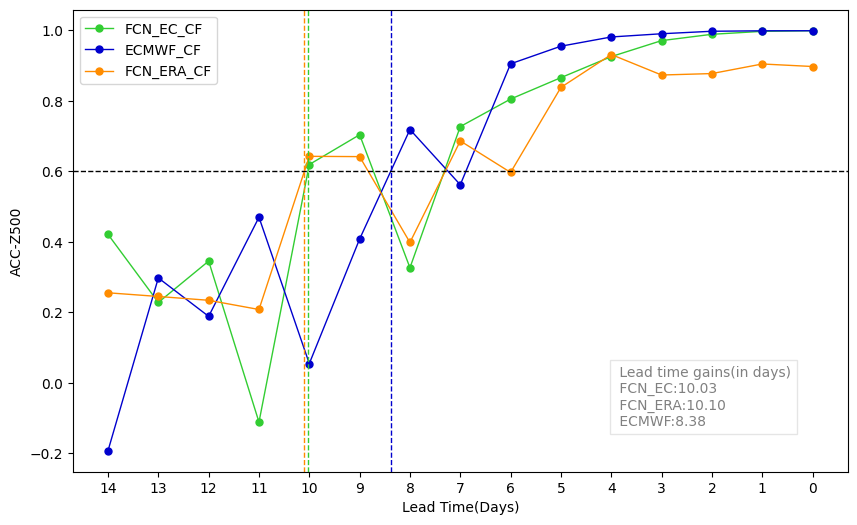

In [31]:
fig = plt.figure(figsize=(10,6))
ax = plt.axes()

x = np.linspace(0, 14, 15)
threshold_ACC = 0.6
x_intersect_fc_ec = np.interp(threshold_ACC, acc_fc_ec_cf_box_big[0:6], x[0:6])
x_intersect_fc_era = np.interp(threshold_ACC, acc_fc_era_box_big[0:6,0],x[0:6])
x_intersect_ec = np.interp(threshold_ACC, acc_ec_cf_box_big, x)


ax.plot(x, acc_fc_ec_cf_box_big,marker='o',label='FCN_EC_CF',linewidth=1,markersize= 5,color = 'limegreen');
ax.plot(x, acc_ec_cf_box_big,marker='o',label='ECMWF_CF',linewidth=1,markersize= 5,color = 'mediumblue');
ax.plot(x, acc_fc_era_box_big[:,0],marker='o',label='FCN_ERA_CF',linewidth=1,markersize=5,color='darkorange');
ax.axhline(threshold_ACC, color='black', linestyle='--',linewidth=1)
ax.axvline(x=x_intersect_fc_ec, color='limegreen', linestyle='--',linewidth=1)
ax.axvline(x=x_intersect_fc_era, color='darkorange', linestyle='--',linewidth=1)
ax.axvline(x=x_intersect_ec, color='mediumblue', linestyle='--',linewidth=1)
ax.set_xticks(x,[14,13,12,11,10,9,8,7,6,5,4,3,2,1,0])
plt.text(0.7,0.1, f' Lead time gains(in days)\n FCN_EC:{14-x_intersect_fc_ec:.2f}\n FCN_ERA:{14-x_intersect_fc_era:.2f}\n ECMWF:{14-x_intersect_ec:.2f}',fontsize=10,color='grey',
         transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.1))
plt.ylabel('ACC-Z500')
plt.xlabel('Lead Time(Days)')#should be from lager value to smaill value
ax.legend()
plt.savefig('/home/kit/imk-tro/gj5173/plots_lead_time_gain/cf_06_29_lg_big.png', bbox_inches='tight',dpi=100)

In [2]:
acc_fc_ec_box_big[14,:] = acc_ec_box_big[14,:]

NameError: name 'acc_ec_box_big' is not defined

In [5]:
acc_fcnv1_ec_z500_big_0629_ens[14,:] = acc_ec_z500_big_0629_ens[14,:]

In [6]:
def calculate_stats_as_xarray(data):
    mean_values = [np.mean(data[i, :]) for i in range(15)]
    median_values = [statistics.median(data[i, :]) for i in range(15)]
    std_dev_values = [np.std(data[i, :]) for i in range(15)]
    
    mean_da = xr.DataArray(mean_values, dims='member', name='mean')
    median_da = xr.DataArray(median_values, dims='member', name='median')
    std_dev_da = xr.DataArray(std_dev_values, dims='member', name='std_dev')
    
    return mean_da, median_da, std_dev_da


ds_mean_ec_ens_box, ds_median_ec_ens_box, ds_std_dev_ec_ens_box = calculate_stats_as_xarray(acc_ec_z500_big_0629_ens)

ds_mean_fcn_ec_ens_box, ds_median_fcn_ec_ens_box, ds_std_dev_fcn_ec_ens_box = calculate_stats_as_xarray(acc_fcnv1_ec_z500_big_0629_ens)

ds_mean_fcn_era_ens_box, ds_median_fcn_era_ens_box, ds_std_dev_fcn_era_ens_box = calculate_stats_as_xarray(acc_fcnv1_era_z500_big_0629_ens )

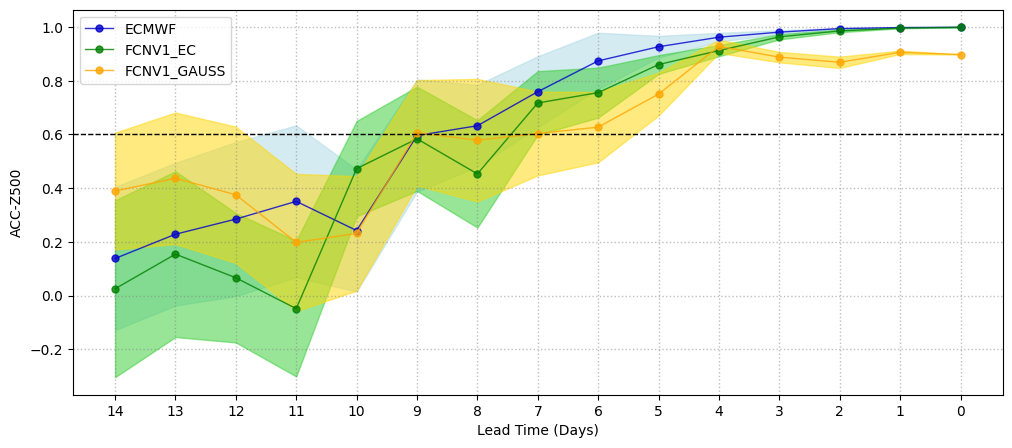

In [7]:
fig = plt.figure(figsize=(12,5))
ax = plt.axes()

x = np.linspace(0, 14, 15)
#threshold_ACC = 0.6


threshold_ACC = 0.6
ax.plot(x, ds_median_ec_ens_box[:],marker='o',label='ECMWF',linewidth=1,markersize= 5,color = 'mediumblue',alpha=0.8);
ax.fill_between(x, ds_median_ec_ens_box - ds_std_dev_ec_ens_box, ds_median_ec_ens_box + ds_std_dev_ec_ens_box, color='lightblue', alpha=0.5)
ax.plot(x, ds_median_fcn_ec_ens_box[:],marker='o',label='FCNV1_EC',linewidth=1,markersize= 5,color = 'green',alpha=0.8);
ax.fill_between(x, ds_median_fcn_ec_ens_box - ds_std_dev_fcn_ec_ens_box, ds_median_fcn_ec_ens_box + ds_std_dev_fcn_ec_ens_box, color='limegreen', alpha=0.5)
ax.plot(x, ds_median_fcn_era_ens_box[:],marker='o',label='FCNV1_GAUSS',linewidth=1,markersize= 5,color = 'orange',alpha=0.8);
ax.fill_between(x, ds_median_fcn_era_ens_box - ds_std_dev_fcn_era_ens_box, ds_median_fcn_era_ens_box + ds_std_dev_fcn_era_ens_box, color='gold', alpha=0.5)
#ax.plot(x, acc_fcnv1_ec_z500_big_0629,marker='o',label='FCN_EC_CF',color = 'limegreen');
#ax.scatter(x, acc_ec_z500_big_0629,marker='o',label='ECMWF_CF',linewidth=1,color = 'mediumblue');
#ax.scatter(x, acc_fcnv1_era_z500_big_0629,marker='o',label='FCN_ERA_CF',color='darkorange');
#ax.plot(x, acc_ec_cf_box,marker='o',label='ECMWF_CF',linewidth=1,markersize= 5,color = 'mediumblue');
#ax.plot(x, acc_fc_era_box[:,0],marker='o',label='FCN_ERA_CF',linewidth=1,markersize=5,color='darkorange');
ax.axhline(threshold_ACC, color='black', linestyle='--',linewidth=1)
ax.set_xticks(x,[14,13,12,11,10,9,8,7,6,5,4,3,2,1,0])
#plt.text(0.7,0.1, f' Lead time gains(in days)\n FCN_EC:{14-x_intersect_fc_ec:.2f}\n FCN_ERA:{14-x_intersect_fc_era:.2f}\n ECMWF:{14-x_intersect_ec:.2f}',fontsize=10,color='grey',
#transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.1))
plt.grid(True, linestyle='dotted', linewidth=1, color='gray', alpha=0.5)
plt.ylabel('ACC-Z500')
plt.xlabel('Lead Time (Days)')#should be from lager value to smaill value
ax.legend()
plt.savefig('/home/kit/imk-tro/gj5173/result_0415/fcnv1_line_plot_0629_z500.png', bbox_inches='tight',dpi=200)

In [ ]:
##################################### only took the lead time of median when it first across the 0.6  line ########################################################################

In [13]:
from scipy.interpolate import interp1d
lead_time = np.linspace(14, 1, 14)
fine_lead_times = np.linspace(14, 1, 1000)
interp_func_ec = interp1d(lead_time, ds_median_ec_ens_box[0:14], kind='linear')
interp_func_fcnv1_ec = interp1d(lead_time, ds_median_fcn_ec_ens_box[0:14], kind='linear')
interp_func_fcnv1_era = interp1d(lead_time,ds_median_fcn_era_ens_box[0:14], kind='linear')
# Interpolate the median data at the finer grid of lead times
interpolated_median_data_ec = interp_func_ec(fine_lead_times)
interpolated_median_data_fcnv1_ec = interp_func_fcnv1_ec(fine_lead_times)
interpolated_median_data_fcnv1_era = interp_func_fcnv1_era(fine_lead_times)
# Find the first lead time when the interpolated median exceeds 0.6
lead_time_index_ec = np.argmax(interpolated_median_data_ec > 0.6)
lead_time_index_fcnv1_ec = np.argmax(interpolated_median_data_fcnv1_ec > 0.6)
lead_time_index_fcnv1_era = np.argmax(interpolated_median_data_fcnv1_era > 0.6)
# Extract the lead time
lead_time_ec = fine_lead_times[lead_time_index_ec]
lead_time_fcnv1_ec = fine_lead_times[lead_time_index_fcnv1_ec]
lead_time_fcnv1_era = fine_lead_times[lead_time_index_fcnv1_era]

In [17]:
lead_time_ec

8.885885885885886

In [18]:
lead_time_fcnv1_ec 

7.441441441441442

In [19]:
lead_time_fcnv1_era

9.016016016016016

In [ ]:
################################### plot the lead time first large than 0.6 ####################################################

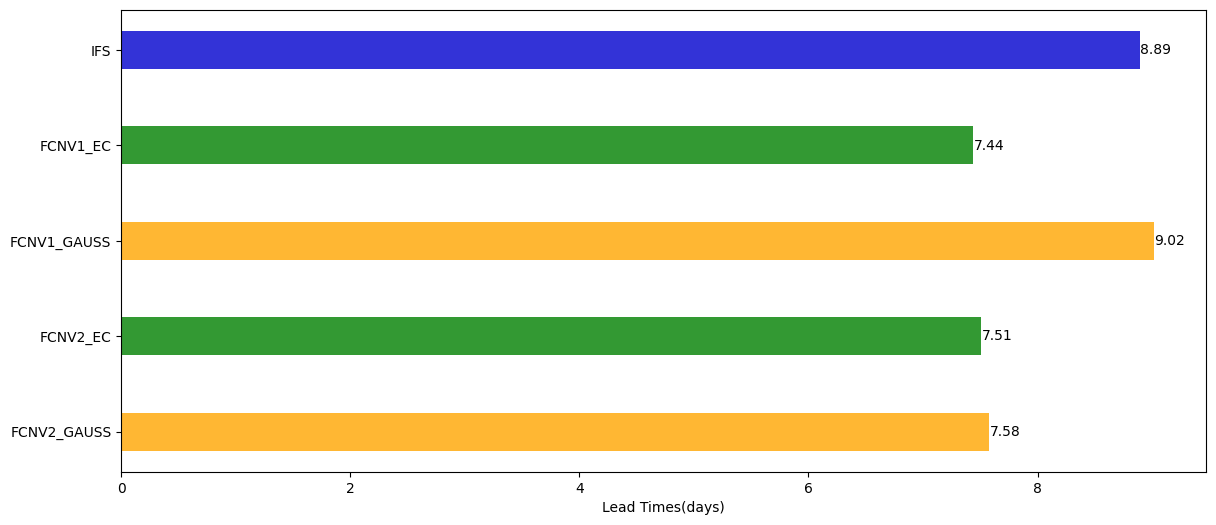

In [20]:
import matplotlib.pyplot as plt
import numpy as np


fig, ax = plt.subplots(figsize=(14,6))

# Example data
colors = ['mediumblue', 'green', 'orange', 'green', 'orange']
model = ('IFS', 'FCNV1_EC', 'FCNV1_GAUSS', 'FCNV2_EC', 'FCNV2_GAUSS')
y_pos = np.arange(len(model))
performance = [8.89, 7.44, 9.02,7.51,7.58]
bar_width = 0.4
bars = ax.barh(y_pos, performance, align='center',color=colors,height = bar_width,alpha=0.8)
ax.set_yticks(y_pos, labels=model)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Lead Times(days)')
for i, bar in enumerate(bars):
    ax.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f'{performance[i]:.2f}',
            va='center', ha='left', color='black')


plt.savefig('/home/kit/imk-tro/gj5173/result_0415/z500_acc_ens_performance_median.png', bbox_inches='tight',dpi=200)

In [ ]:
######################################## biased line plot of T850 #########################################################

In [41]:
########################################################### load climatology dataset ############################################################
clim_t850 = xr.open_dataset('/home/kit/imk-tro/gj5173/tmp/clim_T85000_30day_centered_on_0629_1979-2020_-180.0--60.0degE_25.0-80.0degN_by_grid_point',engine = 'netcdf4')

In [ ]:
##################################### read the era5 data -- t2m, t850, z500 ##############################################################################

In [42]:
ds_era = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Knippertz/ey9908/tmp_Yangfan/data/era5/2021.h5')
ds_era5_t2m_na = ds_era.fields[656:737:4,2,260:40:-1,720:1200]
ds_era5_t850_na = ds_era.fields[656:737:4,5,260:40:-1,720:1200]
ds_era5_z500_na = ds_era.fields[656:737:4,14,260:40:-1,720:1200]
ds_era5_t2m_na_0629 = ds_era5_t2m_na[15,:,:]
ds_era5_t850_na_0629 = ds_era5_t850_na[15,:,:]
ds_era5_z500_na_0629 = ds_era5_z500_na[15,:,:]
ds_era5_t2m_box_mean = np.mean(ds_era5_t2m_na[:,61:141,194:274], axis=(1, 2))
ds_era5_t850_box_mean = np.mean(ds_era5_t850_na[:,61:141,194:274], axis=(1, 2))
ds_era5_z500_box_mean = np.mean(ds_era5_z500_na[:,61:141,194:274], axis=(1, 2))

ds_era5_t2m_box_0629_mean = ds_era5_t2m_box_mean[15]
ds_era5_t850_box_0629_mean = ds_era5_t850_box_mean[15]
ds_era5_z500_box_0629_mean = ds_era5_z500_box_mean[15]

In [4]:
#interpolate function here,should incorporate with other variable later 
def interpolate_function(original_data,target_shape):
    #interpolate from (220,480) to (110,240) 
    #original_data = ds_era_z500
    
    # Define the original grid points along the last two dimensions
    x_orig = np.arange(list(np.shape(original_data))[-2])
    y_orig = np.arange(list(np.shape(original_data))[-1])
    
    # Define the new grid points along the last two dimensions
    y_new = np.linspace(0, list(np.shape(original_data))[-1] - 1, list(np.shape(target_shape.T))[-1])  
    x_new = np.linspace(0, list(np.shape(original_data))[-2]- 1, list(np.shape(target_shape.T))[-2])
    
    
    interpolated_data = original_data.interp(coords={list(original_data.dims)[-2]: x_new, list(original_data.dims)[-1]: y_new}, method='cubic')
    return interpolated_data


In [6]:
#interpolate the era5 data onto the climatology data 
ds_era5_t850_na_0629_interpolated = interpolate_function(ds_era5_t850_na_0629,clim_t850)

In [43]:
def calculate_batch_difference(v1, v2, batch_size):
    """
    Calculate the point-wise difference between two arrays (v2 - v1) in batches.

    Parameters:
    - v1: The first input array.
    - v2: The second input array.
    - batch_size: The desired batch size for processing.

    Returns:
    - An array containing the point-wise differences between v2 and v1.
    """
    # Get the shape of the input arrays
    rows, cols = v1.shape
    
    # Initialize the difference array
    difference = np.empty((rows, cols))

    for i in range(0, rows, batch_size):
        for j in range(0, cols, batch_size):
            batch_variable1 = v1[i:i + batch_size, j:j + batch_size]
            batch_variable2 = v2[i:i + batch_size, j:j + batch_size]
            
            # Calculate the difference point by point for the current batch
            batch_difference = batch_variable2 - batch_variable1

            # Update the difference array with the current batch_difference
            difference[i:i + batch_size, j:j + batch_size] = batch_difference

    return difference

In [8]:
#calculate the anomaly by batch difference function

v2 = ds_era5_t850_na_0629_interpolated
v1 = clim_t850.T[:,:].values

anomaly_era5_t850_na_0629_interpolated = calculate_batch_difference(v1, v2, 50)


In [ ]:
##########################store the variable in case of kernel dying again ########################################


In [5]:
%store -r ds_era5_t2m_na_0629 
%store -r ds_era5_t850_na_0629 
%store -r ds_era5_z500_na_0629 
%store -r ds_era5_t2m_box_mean 
%store -r ds_era5_t850_box_mean
%store -r ds_era5_z500_box_mean 

In [ ]:
############################################## load the ECMWF data---control forecast ############################################################

In [44]:
def read_and_choose_variable_ec(directory, filename_pattern, variable_name, level ):
    # Read data and choose the variable
    files = sorted([f for f in os.listdir(directory) if re.match(filename_pattern, f)])
    variable_data_list = []

    for file in files:
        file_path = os.path.join(directory, file)
        ds = xr.open_dataset(file_path)
        if level is not None:
            variable_data = ds[variable_name][:, level, :, :]
        else:
            variable_data = ds[variable_name]

        variable_data_list.append(variable_data)

    ds_variable_na = xr.DataArray(variable_data_list)

    return ds_variable_na

In [45]:
def process_target_forecast(ds, start_index, step_size, num_iterations):
    'choose the certain date and lead time and get the target forecast'
    ds_target_forecast = []
    for i in range(num_iterations):
        ec_value = ds[(i + 1) * step_size, start_index - i * step_size * 4, :, :]
        ds_target_forecast.append(ec_value)

    ds_target_forecast = xr.DataArray(ds_target_forecast)

    return ds_target_forecast
'''#usage example
start_index = 56
step_size = 1
num_iterations = 15
ds=ds_ec_t2m_box
ds_ec_t2m_box_0629 = process_target_forecast(ds, start_index, step_size, num_iterations)'''

'#usage example\nstart_index = 56\nstep_size = 1\nnum_iterations = 15\nds=ds_ec_t2m_box\nds_ec_t2m_box_0629 = process_target_forecast(ds, start_index, step_size, num_iterations)'

In [46]:
#read data and choose variable----t850
directory = '/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/'
filename_pattern = r'fc_cf_\d{8}_\d{2}_pl\.nc'
variable_name = 't'
level = 1  # 850hpa
ds_ec_t850_na = read_and_choose_variable_ec(directory, filename_pattern, variable_name, level)
#ds_ec_z500_na_0629
#choose the box
ds_ec_t850_box=ds_ec_t850_na[:,:,79:159,194:274]

In [47]:
#choose the target day in the whole NA area
start_index = 56
step_size = 1
num_iterations = 15
ds=ds_ec_t850_na
ds_ec_t850_na_0629 = process_target_forecast(ds, start_index, step_size, num_iterations)

In [17]:
########################################## load the ECMWF data ----- predictability froecast ########################################################

In [48]:
ds_ec_1 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/fc_pf_20210615_00_pl.nc') 
variable_data_ec_1 = ds_ec_1['t'][56,:,1,:,:]
#mean_fcn_ec_1 = np.mean(variable_data_fcn_ec_1, axis=(-2, -1))

ds_ec_2 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/fc_pf_20210616_00_pl.nc') 
variable_data_ec_2 = ds_ec_2['t'][52,:,1,:,:]
#mean_fcn_ec_1 = np.mean(variable_data_fcn_ec_1, axis=(-2, -1))

ds_ec_3 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/fc_pf_20210617_00_pl.nc') 
variable_data_ec_3 = ds_ec_3['t'][48,:,1,:,:]
#mean_fcn_ec_1 = np.mean(variable_data_fcn_ec_1, axis=(-2, -1))

ds_ec_4 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/fc_pf_20210618_00_pl.nc') 
variable_data_ec_4 = ds_ec_4['t'][44,:,1,:,:]
#mean_fcn_ec_1 = np.mean(variable_data_fcn_ec_1, axis=(-2, -1))

ds_ec_5 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/fc_pf_20210619_00_pl.nc') 
variable_data_ec_5 = ds_ec_5['t'][40,:,1,:,:]
#mean_fcn_ec_1 = np.mean(variable_data_fcn_ec_1, axis=(-2, -1))

ds_ec_6 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/fc_pf_20210620_00_pl.nc') 
variable_data_ec_6 = ds_ec_6['t'][36,:,1,:,:]
#mean_fcn_ec_1 = np.mean(variable_data_fcn_ec_1, axis=(-2, -1))

ds_ec_7 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/fc_pf_20210621_00_pl.nc') 
variable_data_ec_7 = ds_ec_7['t'][32,:,1,:,:]
#mean_fcn_ec_1 = np.mean(variable_data_fcn_ec_1, axis=(-2, -1))

ds_ec_8 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/fc_pf_20210622_00_pl.nc') 
variable_data_ec_8 = ds_ec_8['t'][28,:,1,:,:]

ds_ec_9 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/fc_pf_20210623_00_pl.nc') 
variable_data_ec_9 = ds_ec_9['t'][24,:,1,:,:]

ds_ec_10 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/fc_pf_20210624_00_pl.nc') 
variable_data_ec_10 = ds_ec_10['t'][20,:,1,:,:]

ds_ec_11 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/fc_pf_20210625_00_pl.nc') 
variable_data_ec_11 = ds_ec_11['t'][16,:,1,:,:]

ds_ec_12 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/fc_pf_20210626_00_pl.nc') 
variable_data_ec_12 = ds_ec_12['t'][12,:,1,:,:]

ds_ec_13 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/fc_pf_20210627_00_pl.nc') 
variable_data_ec_13 = ds_ec_13['t'][8,:,1,:,:]

ds_ec_14 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/fc_pf_20210628_00_pl.nc') 
variable_data_ec_14 = ds_ec_14['t'][4,:,1,:,:]

ds_ec_15 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/fc_pf_20210629_00_pl.nc') 
variable_data_ec_15 = ds_ec_15['t'][0,:,1,:,:]

In [49]:
new_dimension = 'time'
ds_ec_1_expanded = variable_data_ec_1.expand_dims(**{new_dimension: [0]})
ds_ec_2_expanded = variable_data_ec_2.expand_dims(**{new_dimension: [1]})
ds_ec_3_expanded = variable_data_ec_3.expand_dims(**{new_dimension: [2]})
ds_ec_4_expanded = variable_data_ec_4.expand_dims(**{new_dimension: [3]})
ds_ec_5_expanded = variable_data_ec_5.expand_dims(**{new_dimension: [4]})
ds_ec_6_expanded = variable_data_ec_6.expand_dims(**{new_dimension: [5]})
ds_ec_7_expanded = variable_data_ec_7.expand_dims(**{new_dimension: [6]})
ds_ec_8_expanded = variable_data_ec_8.expand_dims(**{new_dimension: [7]})
ds_ec_9_expanded = variable_data_ec_9.expand_dims(**{new_dimension: [8]})
ds_ec_10_expanded = variable_data_ec_10.expand_dims(**{new_dimension:[9]})
ds_ec_11_expanded = variable_data_ec_11.expand_dims(**{new_dimension: [10]})
ds_ec_12_expanded = variable_data_ec_12.expand_dims(**{new_dimension: [11]})
ds_ec_13_expanded = variable_data_ec_13.expand_dims(**{new_dimension: [12]})
ds_ec_14_expanded = variable_data_ec_14.expand_dims(**{new_dimension: [13]})
ds_ec_15_expanded = variable_data_ec_15.expand_dims(**{new_dimension: [13]})

In [50]:
ds_ec_t850_na_0629_ens = xr.concat([ds_ec_1_expanded,ds_ec_2_expanded,ds_ec_3_expanded,ds_ec_4_expanded,ds_ec_5_expanded,ds_ec_6_expanded,ds_ec_7_expanded,ds_ec_8_expanded,ds_ec_9_expanded,ds_ec_10_expanded,ds_ec_11_expanded,ds_ec_12_expanded,ds_ec_13_expanded,ds_ec_14_expanded,ds_ec_15_expanded],dim=new_dimension)

/home/kit/imk-tro/gj5173/anaconda3/envs/newenvi1/lib/python3.9/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


In [51]:
ds_ec_t850_na_0629_ens = xr.DataArray(ds_ec_t850_na_0629_ens)

In [20]:
#interpolate function here,should incorporate with other variable later 
def interpolate_ecmwf_function(original_data,target_shape):
    #interpolate from (220,480) to (110,240) 
    #original_data = ds_era_z500
    
    # Define the original grid points along the last two dimensions
    x_orig = np.arange(25,80,list(np.shape(original_data))[-2])
    y_orig = np.arange(-180,-60,list(np.shape(original_data))[-1])
    
    # Define the new grid points along the last two dimensions
    y_new = np.linspace(-180,-60,  list(np.shape(target_shape.T))[-1])  
    x_new = np.linspace(25,80,  list(np.shape(target_shape.T))[-2])
    
    
    interpolated_data = original_data.interp(coords={list(original_data.dims)[-2]: x_new, list(original_data.dims)[-1]: y_new}, method='cubic')
    return interpolated_data


In [25]:
#interpolate the ecmwf_cf onto the climatology
ds_ec_t850_na_0629_interpolated = np.zeros((15,110,240),dtype=float)
for i in range(15):
    ds_ec_t850_na_0629_interpolated[i,:,:] = interpolate_function(ds_ec_t850_na_0629[i,:,:],clim_t850)

In [ ]:
#interpolate the ecmwf_ens onto the climatology !!!!!!!Kernel always die
ds_ec_t850_na_0629_ens_interpolated = np.zeros((15,50,110,240),dtype=float)
for i in range(15):
    for j in range(50):
        ds_ec_t850_na_0629_ens_interpolated[i,j,:,:] = interpolate_ecmwf_function(ds_ec_t850_na_0629_ens[i,j,:,:],clim_t850)

In [26]:
%store -r ds_ec_t850_na_0629_ens_interpolated

In [25]:
#use the small batch to calculate the anomaly of ec_cf

anomaly_ec_t850_na_0629_interpolated = np.zeros((15,110,240),dtype=float)
v2 = ds_ec_t850_na_0629_interpolated
v1 = clim_t850.T[:,:]
for i in range(15):
    anomaly_ec_t850_na_0629_interpolated[i,:,:] = calculate_batch_difference(v1,v2[i,::-1,:],50)
#########################!!!!!!!!!!!!!!!!!!!!!!!!!!!!!#######################################
#the reason here might be the latitude oder when you interpolate, go check it

In [26]:
#use the small batch to calculate the anomaly of ec_ens

anomaly_ec_t850_na_0629_ens_interpolated = np.zeros((15,50,110,240),dtype=float)
v2 = ds_ec_t850_na_0629_ens_interpolated
v1 = clim_t850.T[:,:].values
for i in range(15):
    for j in range(50):
        anomaly_ec_t850_na_0629_ens_interpolated[i,j,:,:] = calculate_batch_difference(v1,v2[i,j,:,:], 50)

In [65]:
#use the small batch to calculate the bias field of ec_cf

bias_ec_t850_na_0629 = np.zeros((15,220,480),dtype=float)
v2 = ds_ec_t850_na_0629
v1 = ds_era5_t850_na_0629.values[:,:]
for i in range(15):
    bias_ec_t850_na_0629[i,:,:] = calculate_batch_difference(v1,v2[i,220:0:-1,0:480],50)

In [ ]:
#use the small batch to calculate the bias field of ec_ens
bias_ec_t850_na_0629_ens = np.zeros((15,50,220,480),dtype=float)
v2 = ds_ec_t850_na_0629_ens
v1 = ds_era5_t850_na_0629.values[:,:]
for i in range(15):
    for j in range(50):
        bias_ec_t850_na_0629_ens[i,j,:,:] = calculate_batch_difference(v1,v2[i,j,220:0:-1,0:480],50)

In [39]:
%store -r bias_ec_t850_na_0629
%store -r bias_ec_t850_na_0629_ens

no stored variable or alias bias_ec_t850_na_0629_ens


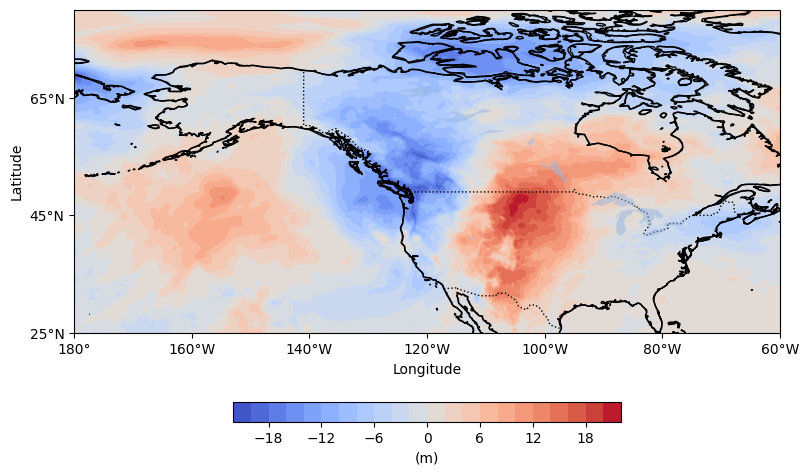

In [62]:
#check for the bias fields
#check the anomaly distribution
lat = np.linspace(25, 80, 220)
lon = np.linspace(-180, -60, 480)
lon_grid, lat_grid = np.meshgrid(lon, lat)


fig = plt.figure(figsize=(10,6))
ax = plt.axes(projection=ccrs.PlateCarree())
x, y = lon_grid, lat_grid  
leftlon, rightlon, lowerlat, upperlat = (-180,-60,25,80)#define map extent
ax.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
                  
# Add map 
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='w')


ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.set_xticks(np.arange(leftlon,rightlon+10,20), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(lowerlat,upperlat,20), crs=ccrs.PlateCarree())

lat_formatter = cticker.LatitudeFormatter()
lon_formatter = cticker.LongitudeFormatter()

ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

# Plot the contour map

#contour1 = ax.contourf(x,y,anomaly_era5_z500_na_0629_interpolated/9.80665,cmap='coolwarm',levels=20)
contour1 = ax.contourf(x,y,bias_ec_t850_na_0629[1,:,:],cmap='coolwarm',levels=20)

cbar = plt.colorbar(contour1, ax=ax, label='(m)',orientation='horizontal',shrink=0.5)

# Set plot title and labels

plt.xlabel('Longitude')
plt.ylabel('Latitude')

#plt.savefig('/home/kit/imk-tro/gj5173/plots07.27/climatology.png', bbox_inches='tight',dpi=100)
# Show the plot
plt.show()

In [ ]:
bias_ec_t850_box_0629_ens_mean = np.mean(bias_ec_t850_na_0629_ens[:,:,79:159,194:274],axis=(-1,-2))
bias_ec_t850_box_0629_mean = np.mean(bias_ec_t850_na_0629[:,79:159,194:274],axis=(-1,-2))

In [2]:
%store -r bias_ec_t850_box_0629_ens_mean
%store -r bias_ec_t850_box_0629_mean

In [ ]:
################################### store the variable in case of kernel death agagin #########################

In [26]:
%store -r anomaly_ec_t850_na_0629_ens_interpolated
%store -r anomaly_ec_t850_na_0629_interpolated
%store -r ds_ec_t850_na_0629_ens_interpolated
%store -r ds_ec_t850_na_0629_interpolated
%store -r ds_ec_t850_na_0629_ens
%store -r ds_ec_t850_na_0629

In [ ]:
#################################################### load the fcnv1_ecmwf data #############################################################################

In [54]:
ds_ec_1 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Knippertz/ey9908/tmp_Yangfan/data/fourcastnet/with_ecmwf_ic/20210615_00_backtransformed.nc') 
variable_data_ec_1 = ds_ec_1['forecast'][:,56,5,:,:]

ds_ec_2 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Knippertz/ey9908/tmp_Yangfan/data/fourcastnet/with_ecmwf_ic/20210616_00_backtransformed.nc') 
variable_data_ec_2 = ds_ec_2['forecast'][:,52,5,:,:]
#mean_fcn_ec_1 = np.mean(variable_data_fcn_ec_1, axis=(-2, -1))

ds_ec_3 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Knippertz/ey9908/tmp_Yangfan/data/fourcastnet/with_ecmwf_ic/20210617_00_backtransformed.nc') 
variable_data_ec_3 = ds_ec_3['forecast'][:,48,5,:,:]
#mean_fcn_ec_1 = np.mean(variable_data_fcn_ec_1, axis=(-2, -1))

ds_ec_4 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Knippertz/ey9908/tmp_Yangfan/data/fourcastnet/with_ecmwf_ic/20210618_00_backtransformed.nc') 
variable_data_ec_4 = ds_ec_4['forecast'][:,44,5,:,:]
#mean_fcn_ec_1 = np.mean(variable_data_fcn_ec_1, axis=(-2, -1))

ds_ec_5 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Knippertz/ey9908/tmp_Yangfan/data/fourcastnet/with_ecmwf_ic/20210619_00_backtransformed.nc') 
variable_data_ec_5 = ds_ec_5['forecast'][:,40,5,:,:]
#mean_fcn_ec_1 = np.mean(variable_data_fcn_ec_1, axis=(-2, -1))

ds_ec_6 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Knippertz/ey9908/tmp_Yangfan/data/fourcastnet/with_ecmwf_ic/20210620_00_backtransformed.nc') 
variable_data_ec_6 = ds_ec_6['forecast'][:,36,5,:,:]
#mean_fcn_ec_1 = np.mean(variable_data_fcn_ec_1, axis=(-2, -1))

ds_ec_7 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Knippertz/ey9908/tmp_Yangfan/data/fourcastnet/with_ecmwf_ic/20210621_00_backtransformed.nc') 
variable_data_ec_7 = ds_ec_7['forecast'][:,32,5,:,:]
#mean_fcn_ec_1 = np.mean(variable_data_fcn_ec_1, axis=(-2, -1))

ds_ec_8 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Knippertz/ey9908/tmp_Yangfan/data/fourcastnet/with_ecmwf_ic/20210622_00_backtransformed.nc') 
variable_data_ec_8 = ds_ec_8['forecast'][:,28,5,:,:]

ds_ec_9 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Knippertz/ey9908/tmp_Yangfan/data/fourcastnet/with_ecmwf_ic/20210623_00_backtransformed.nc') 
variable_data_ec_9 = ds_ec_9['forecast'][:,24,5,:,:]

ds_ec_10 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Knippertz/ey9908/tmp_Yangfan/data/fourcastnet/with_ecmwf_ic/20210624_00_backtransformed.nc') 
variable_data_ec_10 = ds_ec_10['forecast'][:,20,5,:,:]

ds_ec_11 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Knippertz/ey9908/tmp_Yangfan/data/fourcastnet/with_ecmwf_ic/20210625_00_backtransformed.nc') 
variable_data_ec_11 = ds_ec_11['forecast'][:,16,5,:,:]

ds_ec_12 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Knippertz/ey9908/tmp_Yangfan/data/fourcastnet/with_ecmwf_ic/20210626_00_backtransformed.nc') 
variable_data_ec_12 = ds_ec_12['forecast'][:,12,5,:,:]

ds_ec_13 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Knippertz/ey9908/tmp_Yangfan/data/fourcastnet/with_ecmwf_ic/20210627_00_backtransformed.nc') 
variable_data_ec_13 = ds_ec_13['forecast'][:,8,5,:,:]

ds_ec_14 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Knippertz/ey9908/tmp_Yangfan/data/fourcastnet/with_ecmwf_ic/20210628_00_backtransformed.nc') 
variable_data_ec_14 = ds_ec_14['forecast'][:,4,5,:,:]
ds_ec_15 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Knippertz/ey9908/tmp_Yangfan/data/fourcastnet/with_ecmwf_ic/20210629_00_backtransformed.nc') 
variable_data_ec_15 = ds_ec_15['forecast'][:,0,5,:,:]

In [55]:
new_dimension = 'time'
ds_ec_1_expanded = variable_data_ec_1.expand_dims(**{new_dimension: [0]})
ds_ec_2_expanded = variable_data_ec_2.expand_dims(**{new_dimension: [1]})
ds_ec_3_expanded = variable_data_ec_3.expand_dims(**{new_dimension: [2]})
ds_ec_4_expanded = variable_data_ec_4.expand_dims(**{new_dimension: [3]})
ds_ec_5_expanded = variable_data_ec_5.expand_dims(**{new_dimension: [4]})
ds_ec_6_expanded = variable_data_ec_6.expand_dims(**{new_dimension: [5]})
ds_ec_7_expanded = variable_data_ec_7.expand_dims(**{new_dimension: [6]})
ds_ec_8_expanded = variable_data_ec_8.expand_dims(**{new_dimension: [7]})
ds_ec_9_expanded = variable_data_ec_9.expand_dims(**{new_dimension: [8]})
ds_ec_10_expanded = variable_data_ec_10.expand_dims(**{new_dimension:[9]})
ds_ec_11_expanded = variable_data_ec_11.expand_dims(**{new_dimension: [10]})
ds_ec_12_expanded = variable_data_ec_12.expand_dims(**{new_dimension: [11]})
ds_ec_13_expanded = variable_data_ec_13.expand_dims(**{new_dimension: [12]})
ds_ec_14_expanded = variable_data_ec_14.expand_dims(**{new_dimension: [13]})
ds_ec_15_expanded = variable_data_ec_15.expand_dims(**{new_dimension: [14]})

In [56]:
ds_fcnv1_ec_t850_na_0629_ens = xr.concat([ds_ec_1_expanded,ds_ec_2_expanded,ds_ec_3_expanded,ds_ec_4_expanded,ds_ec_5_expanded,ds_ec_6_expanded,ds_ec_7_expanded,ds_ec_8_expanded,ds_ec_9_expanded,ds_ec_10_expanded,ds_ec_11_expanded,ds_ec_12_expanded,ds_ec_13_expanded,ds_ec_14_expanded,ds_ec_15_expanded],dim=new_dimension)

/home/kit/imk-tro/gj5173/anaconda3/envs/newenvi1/lib/python3.9/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


In [57]:
ds_fcnv1_ec_t850_na_0629 = ds_fcnv1_ec_t850_na_0629_ens[:,50,:,:]
ds_fcnv1_ec_t850_na_ens_0629 = ds_fcnv1_ec_t850_na_0629_ens[:,0:50,:,:]

In [13]:
#interpolate the fcnv1_ec_cf onto the climatology
ds_fcnv1_ec_t850_na_0629_interpolated = np.zeros((15,110,240),dtype=float)
for i in range(15):
    ds_fcnv1_ec_t850_na_0629_interpolated[i,:,:] = interpolate_function(ds_fcnv1_ec_t850_na_0629[i,:,:],clim_t850)

In [30]:
#interpolate the fcnv1_ec_ens onto the climatology !!!!!careful with kernel die
ds_fcnv1_ec_t850_na_0629_ens_interpolated = np.zeros((15,50,110,240),dtype=float)
for i in range(15):
    for j in range(50):
        ds_fcnv1_ec_t850_na_0629_ens_interpolated[i,j,:,:] = interpolate_function(ds_fcnv1_ec_t850_na_ens_0629[i,j,:,:],clim_t850)

In [22]:
%store -r ds_fcnv1_ec_t850_na_0629_ens_interpolated

In [31]:
#use the small batch to calculate the anomaly of fcnv1_ec_cf

anomaly_fcnv1_ec_t850_na_0629_interpolated = np.zeros((15,110,240),dtype=float)
v2 = ds_fcnv1_ec_t850_na_0629_interpolated
v1 = clim_t850.T[:,:]
for i in range(15):
    anomaly_fcnv1_ec_t850_na_0629_interpolated[i,:,:] = calculate_batch_difference(v1,v2[i,::-1,:],50)


In [17]:
#use the small batch to calculate the anomaly of fcnv1_ec_ens

anomaly_fcnv1_ec_t850_na_0629_ens_interpolated = np.zeros((15,50,110,240),dtype=float)
v2 = ds_fcnv1_ec_t850_na_0629_ens_interpolated
v1 = clim_t850.T[:,:].values
for i in range(15):
    for j in range(50):
        anomaly_fcnv1_ec_t850_na_0629_ens_interpolated[i,j,:,:] = calculate_batch_difference(v1,v2[i,j,::-1,:], 50)

In [58]:
#use the small batch to calculate the bias field of ec_cf

bias_fcnv1_ec_t850_na_0629 = np.zeros((15,220,480),dtype=float)
v2 = ds_fcnv1_ec_t850_na_0629
v1 = ds_era5_t850_na_0629.values[:,:]
for i in range(15):
    bias_fcnv1_ec_t850_na_0629[i,:,:] = calculate_batch_difference(v1,v2[i,::-1,:],50)

In [59]:
#use the small batch to calculate the bias field of ec_ens
bias_fcnv1_ec_t850_na_0629_ens = np.zeros((15,50,220,480),dtype=float)
v2 = ds_fcnv1_ec_t850_na_ens_0629
v1 = ds_era5_t850_na_0629.values[:,:]
for i in range(15):
    for j in range(50):
        bias_fcnv1_ec_t850_na_0629_ens[i,j,:,:] = calculate_batch_difference(v1,v2[i,j,::-1,:],50)

In [60]:
bias_fcnv1_ec_t850_na_0629_mean = np.mean(bias_fcnv1_ec_t850_na_0629,axis=(-1,-2))
bias_fcnv1_ec_t850_na_0629_ens_mean = np.mean(bias_fcnv1_ec_t850_na_0629_ens,axis=(-1,-2))
bias_fcnv1_ec_t850_box_0629_mean = np.mean(bias_fcnv1_ec_t850_na_0629[:,79:159,194:274],axis=(-1,-2))
bias_fcnv1_ec_t850_box_0629_ens_mean = np.mean(bias_fcnv1_ec_t850_na_0629_ens[:,:,79:159,194:274],axis=(-1,-2))

In [3]:
%store -r bias_fcnv1_ec_t850_na_0629_mean 
%store -r bias_fcnv1_ec_t850_na_0629_ens_mean
%store -r bias_fcnv1_ec_t850_box_0629_mean 
%store -r bias_fcnv1_ec_t850_box_0629_ens_mean

In [ ]:
################ store the variable in case of kernel death #####################################

In [23]:
%store -r anomaly_fcnv1_ec_t850_na_0629_ens_interpolated
%store -r anomaly_fcnv1_ec_t850_na_0629_interpolated
%store -r ds_fcnv1_ec_t850_na_0629_ens_interpolated
%store -r ds_fcnv1_ec_t850_na_0629

In [ ]:
%store ds_fcnv1_ec_t850_na_0629_interpolated

In [ ]:
%store ds_fcnv1_ec_t850_na_ens_0629

In [ ]:
################### load fcnv1_era data ############################################################################

In [61]:
#fcn_era5
ds_fcn_era = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Knippertz/ey9908/tmp_Yangfan/data//fourcastnet/2021_dt_list_ens_backtransformed.nc',engine = 'netcdf4')
ds_fcn_era
fcn_era_z = ds_fcn_era.forecast[:,:,:,5,:,:]

variable_data_ec_1 = fcn_era_z[1,:,56,:,:]


variable_data_ec_2 = fcn_era_z[2,:,52,:,:]
#mean_fcn_ec_1 = np.mean(variable_data_fcn_ec_1, axis=(-2, -1))


variable_data_ec_3 = fcn_era_z[3,:,48,:,:]

variable_data_ec_4 = fcn_era_z[4,:,44,:,:]

variable_data_ec_5 = fcn_era_z[5,:,40,:,:]

variable_data_ec_6 = fcn_era_z[6,:,36,:,:]

variable_data_ec_7 = fcn_era_z[7,:,32,:,:]

variable_data_ec_8 = fcn_era_z[8,:,28,:,:]

variable_data_ec_9 = fcn_era_z[9,:,24,:,:]

variable_data_ec_10 = fcn_era_z[10,:,20,:,:]

variable_data_ec_11 = fcn_era_z[12,:,16,:,:]

variable_data_ec_12 = fcn_era_z[13,:,12,:,:]

variable_data_ec_13 = fcn_era_z[14,:,8,:,:]

variable_data_ec_14 = fcn_era_z[15,:,4,:,:]

variable_data_ec_15 = fcn_era_z[16,:,0,:,:]

In [47]:
new_dimension = 'time'
ds_ec_1_expanded = variable_data_ec_1.expand_dims(**{new_dimension: [0]})
ds_ec_2_expanded = variable_data_ec_2.expand_dims(**{new_dimension: [1]})
ds_ec_3_expanded = variable_data_ec_3.expand_dims(**{new_dimension: [2]})
ds_ec_4_expanded = variable_data_ec_4.expand_dims(**{new_dimension: [3]})
ds_ec_5_expanded = variable_data_ec_5.expand_dims(**{new_dimension: [4]})
ds_ec_6_expanded = variable_data_ec_6.expand_dims(**{new_dimension: [5]})
ds_ec_7_expanded = variable_data_ec_7.expand_dims(**{new_dimension: [6]})
ds_ec_8_expanded = variable_data_ec_8.expand_dims(**{new_dimension: [7]})
ds_ec_9_expanded = variable_data_ec_9.expand_dims(**{new_dimension: [8]})
ds_ec_10_expanded = variable_data_ec_10.expand_dims(**{new_dimension:[9]})
ds_ec_11_expanded = variable_data_ec_11.expand_dims(**{new_dimension: [10]})
ds_ec_12_expanded = variable_data_ec_12.expand_dims(**{new_dimension: [11]})
ds_ec_13_expanded = variable_data_ec_13.expand_dims(**{new_dimension: [12]})
ds_ec_14_expanded = variable_data_ec_14.expand_dims(**{new_dimension: [13]})
ds_ec_15_expanded = variable_data_ec_15.expand_dims(**{new_dimension: [14]})

In [64]:
ds_fcnv1_era_t850_na_0629_ens = xr.concat([ds_ec_1_expanded,ds_ec_2_expanded,ds_ec_3_expanded,ds_ec_4_expanded,ds_ec_5_expanded,ds_ec_6_expanded,ds_ec_7_expanded,ds_ec_8_expanded,ds_ec_9_expanded,ds_ec_10_expanded,ds_ec_11_expanded,ds_ec_12_expanded,ds_ec_13_expanded,ds_ec_14_expanded,ds_ec_15_expanded],dim=new_dimension)

/home/kit/imk-tro/gj5173/anaconda3/envs/newenvi1/lib/python3.9/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


In [65]:
ds_fcnv1_era_t850_na_0629 = ds_fcnv1_era_t850_na_0629_ens[:,0,:,:]
ds_fcnv1_era_t850_na_ens_0629 = ds_fcnv1_era_t850_na_0629_ens[:,1:51,:,:]

In [39]:
#interpolate the fcnv1_era_cf onto the climatology
ds_fcnv1_era_t850_na_0629_interpolated = np.zeros((15,110,240),dtype=float)
for i in range(15):
    ds_fcnv1_era_t850_na_0629_interpolated[i,:,:] = interpolate_function(ds_fcnv1_era_t850_na_0629[i,:,:],clim_t850)

In [ ]:
#interpolate the fcnv1_ec_ens onto the climatology !!!!!!!!careful with the kernel dead issue
ds_fcnv1_era_t850_na_0629_ens_interpolated = np.zeros((15,50,110,240),dtype=float)
for i in range(15):
    for j in range(50):
        ds_fcnv1_era_t850_na_0629_ens_interpolated[i,j,:,:] = interpolate_function(ds_fcnv1_era_t850_na_ens_0629[i,j,:,:],clim_t850)

In [40]:
%store -r ds_fcnv1_era_t850_na_0629_ens_interpolated

In [41]:
#use the small batch to calculate the anomaly of fcnv1_era_cf

anomaly_fcnv1_era_t850_na_0629_interpolated = np.zeros((15,110,240),dtype=float)
v2 = ds_fcnv1_era_t850_na_0629_interpolated
v1 = clim_t850.T[:,:]
for i in range(15):
    anomaly_fcnv1_era_t850_na_0629_interpolated[i,:,:] = calculate_batch_difference(v1,v2[i,::-1,:],50)


In [42]:
#use the small batch to calculate the anomaly of fcnv1_era_ens

anomaly_fcnv1_era_t850_na_0629_ens_interpolated = np.zeros((15,50,110,240),dtype=float)
v2 = ds_fcnv1_era_t850_na_0629_ens_interpolated
v1 = clim_t850.T[:,:].values
for i in range(15):
    for j in range(50):
        anomaly_fcnv1_era_t850_na_0629_ens_interpolated[i,j,:,:] = calculate_batch_difference(v1,v2[i,j,::-1,:], 50)

In [66]:
#use the small batch to calculate the bias field of ec_cf

bias_fcnv1_era_t850_na_0629 = np.zeros((15,220,480),dtype=float)
v2 = ds_fcnv1_era_t850_na_0629
v1 = ds_era5_t850_na_0629.values[:,:]
for i in range(15):
    bias_fcnv1_era_t850_na_0629[i,:,:] = calculate_batch_difference(v1,v2[i,::-1,:],50)

In [67]:
#use the small batch to calculate the bias field of ec_ens
bias_fcnv1_era_t850_na_0629_ens = np.zeros((15,50,220,480),dtype=float)
v2 = ds_fcnv1_era_t850_na_ens_0629
v1 = ds_era5_t850_na_0629.values[:,:]
for i in range(15):
    for j in range(50):
        bias_fcnv1_era_t850_na_0629_ens[i,j,:,:] = calculate_batch_difference(v1,v2[i,j,::-1,:],50)

In [68]:
bias_fcnv1_era_t850_na_0629_mean = np.mean(bias_fcnv1_era_t850_na_0629,axis=(-1,-2))
bias_fcnv1_era_t850_na_0629_ens_mean = np.mean(bias_fcnv1_era_t850_na_0629_ens,axis=(-1,-2))
bias_fcnv1_era_t850_box_0629_mean = np.mean(bias_fcnv1_era_t850_na_0629[:,79:159,194:274],axis=(-1,-2))
bias_fcnv1_era_t850_box_0629_ens_mean = np.mean(bias_fcnv1_era_t850_na_0629_ens[:,:,79:159,194:274],axis=(-1,-2))

In [4]:
%store -r bias_fcnv1_era_t850_na_0629_mean
%store -r bias_fcnv1_era_t850_na_0629_ens_mean
%store -r bias_fcnv1_era_t850_box_0629_mean
%store -r bias_fcnv1_era_t850_box_0629_ens_mean

In [ ]:
################################## save the variables ###################################################

In [ ]:
%store anomaly_fcnv1_era_t850_na_0629_ens_interpolated
%store anomaly_fcnv1_era_t850_na_0629_interpolated
%store ds_fcnv1_era_t850_na_0629_ens_interpolated
%store ds_fcnv1_era_t850_na_0629_interpolated
%store ds_fcnv1_era_t850_na_0629_ens
%store ds_fcnv1_era_t850_na_0629

In [ ]:
%store anomaly_fcnv1_ec_t850_na_0629_ens_interpolated
%store anomaly_fcnv1_ec_t850_na_0629_interpolated
%store ds_fcnv1_ec_t850_na_0629_ens_interpolated
%store ds_fcnv1_ec_t850_na_0629_interpolated
%store ds_fcnv1_ec_t850_na_0629_ens
%store ds_fcnv1_ec_t850_na_0629

In [ ]:
%store anomaly_ec_t850_na_0629_ens_interpolated
%store anomaly_ec_t850_na_0629_interpolated
%store ds_ec_t850_na_0629_ens_interpolated
%store ds_ec_t850_na_0629_interpolated
%store ds_ec_t850_na_0629_ens
%store ds_ec_t850_na_0629

In [ ]:
######################################### ACC and Bias line plot of T850 ###################################################

In [24]:
import statistics
mean_ec_ens_box = []
std_dev_ec_ens_box = []
median_ec_ens_box = []

for i in range(15):
    mean = np.mean(bias_ec_t850_box_0629_ens_mean[i,:])
    median = statistics.median(bias_ec_t850_box_0629_ens_mean[i,:])
    std_dev = np.std(bias_ec_t850_box_0629_ens_mean[i,:])
    mean_ec_ens_box.append(mean)
    std_dev_ec_ens_box.append(std_dev)
    median_ec_ens_box.append(median)

    
bias_mean_ec_ens_box =xr.DataArray(mean_ec_ens_box)
bias_std_dev_ec_ens_box =xr.DataArray(std_dev_ec_ens_box)
bias_median_ec_ens_box =xr.DataArray(median_ec_ens_box)

In [31]:
%store -r bias_fcnv1_ec_t850_box_0629_mean 
%store -r bias_fcnv1_ec_t850_box_0629_ens_mean

In [25]:
import statistics
mean_fcn_ec_ens_box = []
std_dev_fcn_ec_ens_box = []
median_fcn_ec_ens_box = []

for i in range(15):
    mean = np.mean(bias_fcnv1_ec_t850_box_0629_ens_mean[i,:])
    median = statistics.median(bias_fcnv1_ec_t850_box_0629_ens_mean[i,:])
    std_dev = np.std(bias_fcnv1_ec_t850_box_0629_ens_mean[i,:])
    mean_fcn_ec_ens_box.append(mean)
    std_dev_fcn_ec_ens_box.append(std_dev)
    median_fcn_ec_ens_box.append(median)

    
bias_mean_fcnv1_ec_ens_box =xr.DataArray(mean_fcn_ec_ens_box)
bias_std_dev_fcnv1_ec_ens_box =xr.DataArray(std_dev_fcn_ec_ens_box)
bias_median_fcnv1_ec_ens_box =xr.DataArray(median_fcn_ec_ens_box)

<xarray.DataArray (dim_0: 15)>
array([-12.43947077, -11.94390483, -15.54034226, -14.18454177,
        -8.63962399,  -8.03660436,  -9.35872431,  -5.96589638,
        -7.84397634,  -3.67017432,  -2.37953391,  -1.10372951,
        -0.84085066,  -0.63308445, -22.57016731])
Dimensions without coordinates: dim_0

In [28]:
%store -r bias_fcnv1_ec_t850_box_0629_mean 
%store -r bias_fcnv1_ec_t850_box_0629_ens_mean

In [29]:
import statistics
mean_fcn_era_ens_box = []
std_dev_fcn_era_ens_box = []
median_fcn_era_ens_box = []

for i in range(1,15):
    mean = np.mean(bias_fcnv1_era_t850_box_0629_ens_mean[i,:])
    median = statistics.median(bias_fcnv1_era_t850_box_0629_ens_mean[i,:])
    std_dev = np.std(bias_fcnv1_era_t850_box_0629_ens_mean[i,:])
    mean_fcn_era_ens_box.append(mean)
    std_dev_fcn_era_ens_box.append(std_dev)
    median_fcn_era_ens_box.append(median)

mean_fcn_era_ens_box.insert(0,mean_1) 
std_dev_fcn_era_ens_box.insert(0,std_dev_1) 
median_fcn_era_ens_box.insert(0,median_1) 
bias_mean_fcnv1_era_ens_box =xr.DataArray(mean_fcn_era_ens_box)
bias_std_dev_fcnv1_era_ens_box =xr.DataArray(std_dev_fcn_era_ens_box)
bias_median_fcnv1_era_ens_box =xr.DataArray(median_fcn_era_ens_box)

In [26]:
#delete the outliers and calculate the statistics again
a = bias_fcnv1_era_t850_box_0629_ens_mean[0,:]
b = list(a)
#bias_fcnv1_era_t850_box_0629_ens_mean[0,25] = None
del b[25]

In [27]:
bias_fcnv1_era_t850_box_0629_1_mean_edited =b

In [28]:
mean_1 = np.mean(bias_fcnv1_era_t850_box_0629_1_mean_edited)
median_1 = statistics.median(bias_fcnv1_era_t850_box_0629_1_mean_edited)
std_dev_1 = np.std(bias_fcnv1_era_t850_box_0629_1_mean_edited)
bias_mean_fcnv1_era_1_box =xr.DataArray(mean_1)
bias_std_dev_fcnv1_era_1_box =xr.DataArray(std_dev_1)
bias_median_fcnv1_era_1_box =xr.DataArray(median_1)

In [30]:
bias_median_fcnv1_ec_ens_box[14]=bias_median_ec_ens_box[14]
bias_std_dev_fcnv1_ec_ens_box[14]=bias_std_dev_ec_ens_box[14]

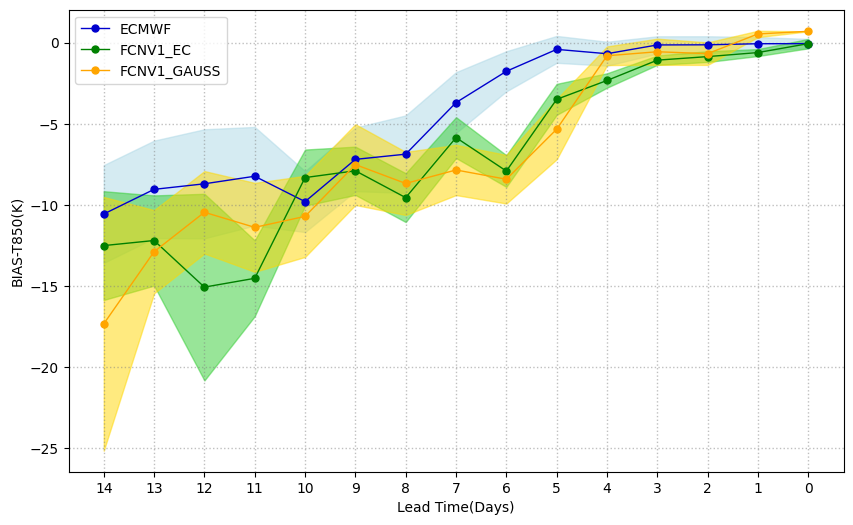

In [34]:
fig = plt.figure(figsize=(10,6))
ax = plt.axes()

x = np.linspace(0, 14, 15)
#threshold_ACC = 0.6


threshold_ACC = 0.6
ax.plot(x, bias_median_ec_ens_box[:],marker='o',label='ECMWF',linewidth=1,markersize= 5,color = 'mediumblue');
ax.fill_between(x, bias_median_ec_ens_box - bias_std_dev_ec_ens_box, bias_median_ec_ens_box + bias_std_dev_ec_ens_box, color='lightblue', alpha=0.5)

ax.plot(x, bias_median_fcnv1_ec_ens_box[:],marker='o',label='FCNV1_EC',linewidth=1,markersize= 5,color = 'green');
ax.fill_between(x, bias_median_fcnv1_ec_ens_box- bias_std_dev_fcnv1_ec_ens_box, bias_median_fcnv1_ec_ens_box + bias_std_dev_fcnv1_ec_ens_box, color='limegreen', alpha=0.5)

ax.plot(x, bias_median_fcnv1_era_ens_box[:],marker='o',label='FCNV1_GAUSS',linewidth=1,markersize= 5,color = 'orange');
ax.fill_between(x, bias_median_fcnv1_era_ens_box - bias_std_dev_fcnv1_era_ens_box, bias_median_fcnv1_era_ens_box + bias_std_dev_fcnv1_era_ens_box, color='gold', alpha=0.5)

#ax.plot(x, acc_ec_cf_box,marker='o',label='ECMWF_CF',linewidth=1,markersize= 5,color = 'mediumblue');
#ax.plot(x, acc_fc_era_box[:,0],marker='o',label='FCN_ERA_CF',linewidth=1,markersize=5,color='darkorange');
#ax.axhline(-5, color='black', linestyle='--',linewidth=1)
ax.set_xticks(x,[14,13,12,11,10,9,8,7,6,5,4,3,2,1,0])
#plt.text(0.7,0.1, f' Lead time gains(in days)\n FCN_EC:{14-x_intersect_fc_ec:.2f}\n FCN_ERA:{14-x_intersect_fc_era:.2f}\n ECMWF:{14-x_intersect_ec:.2f}',fontsize=10,color='grey',
#transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.1))
plt.grid(True, linestyle='dotted', linewidth=1, color='gray', alpha=0.5)
plt.ylabel('BIAS-T850(K)')
plt.xlabel('Lead Time(Days)')#should be from lager value to smaill value
ax.legend()
plt.savefig('/home/kit/imk-tro/gj5173/not_finalized_yet_plots/line_plot_0629_bias_t850_WITHOUTbaselined.png', bbox_inches='tight',dpi=100)

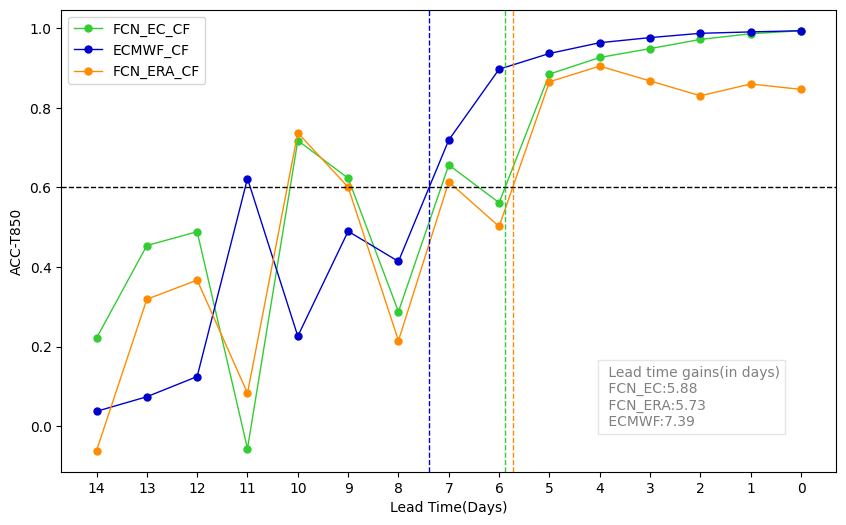

In [120]:
fig = plt.figure(figsize=(10,6))
ax = plt.axes()

x = np.linspace(0, 14, 15)
threshold_ACC = 0.6
x_intersect_fc_ec = np.interp(threshold_ACC, acc_fc_ec_box_big_t850_cf[8:14], x[8:14])
x_intersect_fc_era = np.interp(threshold_ACC, acc_fc_era_box_big_t850_cf[8:14],x[8:14])
x_intersect_ec = np.interp(threshold_ACC, acc_ec_box_big_t850_cf[6:14], x[6:14])


ax.plot(x, acc_fc_ec_box_big_t850_cf,marker='o',label='FCN_EC_CF',linewidth=1,markersize= 5,color = 'limegreen');
ax.plot(x, acc_ec_box_big_t850_cf,marker='o',label='ECMWF_CF',linewidth=1,markersize= 5,color = 'mediumblue');
ax.plot(x, acc_fc_era_box_big_t850_cf,marker='o',label='FCN_ERA_CF',linewidth=1,markersize=5,color='darkorange');
ax.axhline(threshold_ACC, color='black', linestyle='--',linewidth=1)
ax.axvline(x=x_intersect_fc_ec, color='limegreen', linestyle='--',linewidth=1)
ax.axvline(x=x_intersect_fc_era, color='darkorange', linestyle='--',linewidth=1)
ax.axvline(x=x_intersect_ec, color='mediumblue', linestyle='--',linewidth=1)
ax.set_xticks(x,[14,13,12,11,10,9,8,7,6,5,4,3,2,1,0])
plt.text(0.7,0.1, f' Lead time gains(in days)\n FCN_EC:{14-x_intersect_fc_ec:.2f}\n FCN_ERA:{14-x_intersect_fc_era:.2f}\n ECMWF:{14-x_intersect_ec:.2f}',fontsize=10,color='grey',
         transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.1))
plt.ylabel('ACC-T850')
plt.xlabel('Lead Time(Days)')#should be from lager value to smaill value
ax.legend()
plt.savefig('/home/kit/imk-tro/gj5173/plots_lead_time_gain/cf_06_29_lg_big_t850.png', bbox_inches='tight',dpi=100)

In [121]:
import statistics
mean_ec_ens_box = []
std_dev_ec_ens_box = []
median_ec_ens_box = []

for i in range(15):
    mean = np.mean(acc_ec_box_big_t850_pf[i,:])
    median = statistics.median(acc_ec_box_big_t850_pf[i,:])
    std_dev = np.std(acc_ec_box_big_t850_pf[i,:])
    mean_ec_ens_box.append(mean)
    std_dev_ec_ens_box.append(std_dev)
    median_ec_ens_box.append(median)

    
ds_mean_ec_ens_box =xr.DataArray(mean_ec_ens_box)
ds_std_dev_ec_ens_box =xr.DataArray(std_dev_ec_ens_box)
ds_median_ec_ens_box =xr.DataArray(median_ec_ens_box)

import statistics
mean_fcn_ec_ens_box = []
std_dev_fcn_ec_ens_box = []
median_fcn_ec_ens_box = []

for i in range(15):
    mean = np.mean(acc_fc_ec_box_big_t850_pf[i,:])
    median = statistics.median(acc_fc_ec_box_big_t850_pf[i,:])
    std_dev = np.std(acc_fc_ec_box_big_t850_pf[i,:])
    mean_fcn_ec_ens_box.append(mean)
    std_dev_fcn_ec_ens_box.append(std_dev)
    median_fcn_ec_ens_box.append(median)

    
ds_mean_fcn_ec_ens_box =xr.DataArray(mean_fcn_ec_ens_box)
ds_std_dev_fcn_ec_ens_box =xr.DataArray(std_dev_fcn_ec_ens_box)
ds_median_fcn_ec_ens_box =xr.DataArray(median_fcn_ec_ens_box)

import statistics
mean_fcn_era_ens_box = []
std_dev_fcn_era_ens_box = []
median_fcn_era_ens_box = []

for i in range(15):
    mean = np.mean(acc_fc_era_box_big_t850_pf[i,:])
    median = statistics.median(acc_fc_era_box_big_t850_pf[i,:])
    std_dev = np.std(acc_fc_era_box_big_t850_pf[i,:])
    mean_fcn_era_ens_box.append(mean)
    std_dev_fcn_era_ens_box.append(std_dev)
    median_fcn_era_ens_box.append(median)

    
ds_mean_fcn_era_ens_box =xr.DataArray(mean_fcn_era_ens_box)
ds_std_dev_fcn_era_ens_box =xr.DataArray(std_dev_fcn_era_ens_box)
ds_median_fcn_era_ens_box =xr.DataArray(median_fcn_era_ens_box)

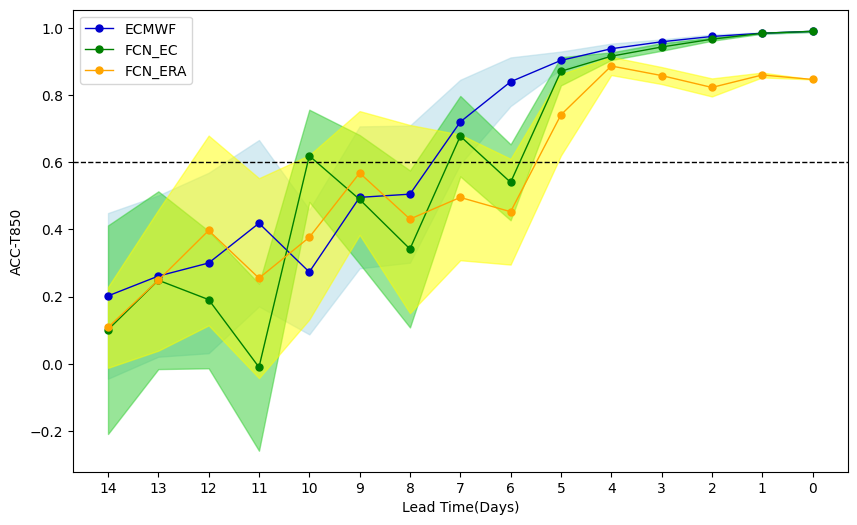

In [122]:
fig = plt.figure(figsize=(10,6))
ax = plt.axes()

x = np.linspace(0, 14, 15)
#threshold_ACC = 0.6


threshold_ACC = 0.6
ax.plot(x, median_ec_ens_box[:],marker='o',label='ECMWF',linewidth=1,markersize= 5,color = 'mediumblue');
ax.fill_between(x, ds_median_ec_ens_box - ds_std_dev_ec_ens_box, ds_median_ec_ens_box + ds_std_dev_ec_ens_box, color='lightblue', alpha=0.5)
ax.plot(x, median_fcn_ec_ens_box[:],marker='o',label='FCN_EC',linewidth=1,markersize= 5,color = 'green');
ax.fill_between(x, ds_median_fcn_ec_ens_box - ds_std_dev_fcn_ec_ens_box, ds_median_fcn_ec_ens_box + ds_std_dev_fcn_ec_ens_box, color='limegreen', alpha=0.5)
ax.plot(x, median_fcn_era_ens_box[:],marker='o',label='FCN_ERA',linewidth=1,markersize= 5,color = 'orange');
ax.fill_between(x, ds_median_fcn_era_ens_box - ds_std_dev_fcn_era_ens_box, ds_median_fcn_era_ens_box + ds_std_dev_fcn_era_ens_box, color='yellow', alpha=0.5)
#ax.plot(x, acc_ec_cf_box,marker='o',label='ECMWF_CF',linewidth=1,markersize= 5,color = 'mediumblue');
#ax.plot(x, acc_fc_era_box[:,0],marker='o',label='FCN_ERA_CF',linewidth=1,markersize=5,color='darkorange');
ax.axhline(threshold_ACC, color='black', linestyle='--',linewidth=1)
ax.set_xticks(x,[14,13,12,11,10,9,8,7,6,5,4,3,2,1,0])
#plt.text(0.7,0.1, f' Lead time gains(in days)\n FCN_EC:{14-x_intersect_fc_ec:.2f}\n FCN_ERA:{14-x_intersect_fc_era:.2f}\n ECMWF:{14-x_intersect_ec:.2f}',fontsize=10,color='grey',
#transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.1))
plt.ylabel('ACC-T850')
plt.xlabel('Lead Time(Days)')#should be from lager value to smaill value
ax.legend()
plt.savefig('/home/kit/imk-tro/gj5173/plots_lead_time_gain/ens_06_29_lg_big_1_t850.png', bbox_inches='tight',dpi=100)

In [ ]:
###################################### lead time gain plot ###########################################################

In [ ]:
###################################### acc t850 lead time gain plot #######################################################

In [32]:
import numpy as np
from scipy.interpolate import interp1d
lt_gain_ec_pf=[]
for i in range(50):
    data = acc_ec_box_t850_pf[::-1,i]
    x_values = np.arange(len(data))#set
    interp_function = interp1d(x_values, data, kind='linear', fill_value='extrapolate')#set
    fine_x_values = np.linspace(0, len(data) - 1, 1000)#set
    interpolated_data = interp_function(fine_x_values)
    index_of_first_point = np.where(interpolated_data < 0.6)[0][0]
    x_value = fine_x_values[index_of_first_point]
    x_value_reverse = 14-x_value
    lt_gain_ec_pf.append(x_value)
#lt_gain_ec_pf

In [19]:
np.shape(acc_fc_ec_box_t850_pf)

(15, 50)

In [39]:
lt_gain_fc_ec_pf=[]
for i in range(50):
    data = acc_fc_ec_box_t850_pf[::-1,i]
    x_values = np.arange(len(data))#set
    interp_function = interp1d(x_values, data, kind='linear', fill_value='extrapolate')#set
    fine_x_values = np.linspace(0, len(data) - 1, 1000)#set
    interpolated_data = interp_function(fine_x_values)
    index_of_first_point = np.where(interpolated_data < 0.5)[0][0]
    x_value = fine_x_values[index_of_first_point]
    x_value_reverse = 14-x_value
    
    lt_gain_fc_ec_pf.append(x_value)

In [41]:
lt_gain_fc_era_pf=[]
for i in range(50):
    data = acc_fc_era_box_t850_pf[::-1,i]
    x_values = np.arange(len(data))#set
    interp_function = interp1d(x_values, data, kind='linear', fill_value='extrapolate')#set
    fine_x_values = np.linspace(0, len(data) - 1, 1000)#set
    interpolated_data = interp_function(fine_x_values)
    index_of_first_point = np.where(interpolated_data < 0.6)[0][0]
    x_value = fine_x_values[index_of_first_point]
    x_value_reverse = 14-x_value
    lt_gain_fc_era_pf.append(x_value)

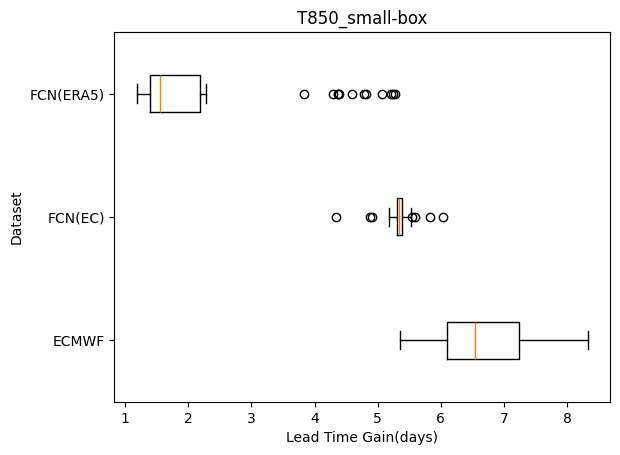

In [43]:
boxprops = dict(color='black', linewidth=1)
colors = [ 'lightblue','lightgreen','lightpink']
#boxprops = dict(color='blue', linewidth=2)
plt.boxplot([lt_gain_ec_pf, lt_gain_fc_ec_pf, lt_gain_fc_era_pf], labels=['ECMWF', 'FCN(EC)', 'FCN(ERA5)'],vert=False,boxprops=boxprops,showfliers=True)


plt.ylabel('Dataset')
plt.xlabel('Lead Time Gain(days)')

plt.title('T850_small-box')
plt.savefig('/home/kit/imk-tro/gj5173/plots_lead_time_gain/t850_small_lg_boxplot', bbox_inches='tight',dpi=100)

In [44]:
import numpy as np
from scipy.interpolate import interp1d
lt_gain_ec_pf_large=[]
for i in range(50):
    data = acc_ec_box_big_t850_pf[::-1,i]
    x_values = np.arange(len(data))#set
    interp_function = interp1d(x_values, data, kind='linear', fill_value='extrapolate')#set
    fine_x_values = np.linspace(0, len(data) - 1, 1000)#set
    interpolated_data = interp_function(fine_x_values)
    index_of_first_point = np.where(interpolated_data < 0.6)[0][0]
    x_value = fine_x_values[index_of_first_point]
    x_value_reverse = 14-x_value
    lt_gain_ec_pf_large.append(x_value)
#lt_gain_ec_pf


lt_gain_fc_ec_pf_large=[]
for i in range(50):
    data = acc_fc_ec_box_big_t850_pf[::-1,i]
    x_values = np.arange(len(data))#set
    interp_function = interp1d(x_values, data, kind='linear', fill_value='extrapolate')#set
    fine_x_values = np.linspace(0, len(data) - 1, 1000)#set
    interpolated_data = interp_function(fine_x_values)
    index_of_first_point = np.where(interpolated_data < 0.6)[0][0]
    x_value = fine_x_values[index_of_first_point]
    x_value_reverse = 14-x_value
    lt_gain_fc_ec_pf_large.append(x_value)



lt_gain_fc_era_pf_large=[]
for i in range(50):
    data = acc_fc_era_box_big_t850_pf[::-1,i]
    x_values = np.arange(len(data))#set
    interp_function = interp1d(x_values, data, kind='linear', fill_value='extrapolate')#set
    fine_x_values = np.linspace(0, len(data) - 1, 1000)#set
    interpolated_data = interp_function(fine_x_values)
    index_of_first_point = np.where(interpolated_data < 0.6)[0][0]
    x_value = fine_x_values[index_of_first_point]
    x_value_reverse = 14-x_value
    lt_gain_fc_era_pf_large.append(x_value)


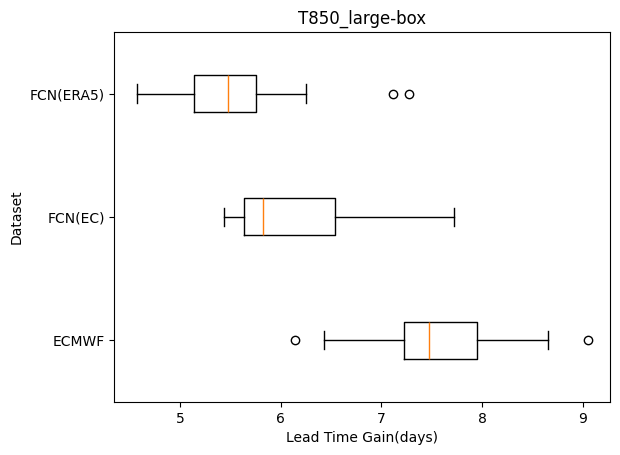

In [45]:
boxprops = dict(color='black', linewidth=1)
colors = [ 'lightblue','lightgreen','lightpink']
#boxprops = dict(color='blue', linewidth=2)
plt.boxplot([lt_gain_ec_pf_large, lt_gain_fc_ec_pf_large, lt_gain_fc_era_pf_large], labels=['ECMWF', 'FCN(EC)', 'FCN(ERA5)'],vert=False,boxprops=boxprops,showfliers=True)


plt.ylabel('Dataset')
plt.xlabel('Lead Time Gain(days)')

plt.title('T850_large-box')
plt.savefig('/home/kit/imk-tro/gj5173/plots_lead_time_gain/t850_large_lg_boxplot', bbox_inches='tight',dpi=100)

In [ ]:
###################################### bias t850 lead time gain plot ######################################################

In [5]:
bias_fcnv1_ec_t850_box_0629_ens_mean[14,:] = bias_ec_t850_box_0629_ens_mean[14,:]

In [11]:
import numpy as np
from scipy.interpolate import interp1d
lt_gain_ec_pf_large=[]
for i in range(50):
    data = bias_ec_t850_box_0629_ens_mean[::-1,i]
    x_values = np.arange(len(data))#set
    interp_function = interp1d(x_values, data, kind='linear', fill_value='extrapolate')#set
    fine_x_values = np.linspace(0, len(data) - 1, 1000)#set
    interpolated_data = interp_function(fine_x_values)
    index_of_first_point = np.where(interpolated_data < -5)[0][0]
    x_value = fine_x_values[index_of_first_point]
    #x_value_reverse = 13-x_value
    lt_gain_ec_pf_large.append(x_value)
#lt_gain_ec_pf

In [12]:
lt_gain_ec_pf_large

[6.8108108108108105,
 7.875875875875876,
 8.422422422422422,
 7.7357357357357355,
 7.4274274274274275,
 7.175175175175175,
 7.623623623623623,
 8.072072072072071,
 8.016016016016016,
 6.656656656656657,
 7.595595595595595,
 7.147147147147147,
 8.1001001001001,
 7.441441441441442,
 8.436436436436436,
 7.147147147147147,
 7.60960960960961,
 7.217217217217217,
 7.931931931931932,
 6.656656656656657,
 7.455455455455455,
 7.245245245245245,
 8.604604604604605,
 8.94094094094094,
 7.371371371371371,
 7.245245245245245,
 6.936936936936937,
 5.871871871871872,
 7.7357357357357355,
 7.777777777777778,
 8.38038038038038,
 7.931931931931932,
 6.656656656656657,
 6.698698698698698,
 7.413413413413413,
 7.049049049049049,
 7.5675675675675675,
 6.712712712712713,
 8.142142142142141,
 6.768768768768768,
 7.301301301301301,
 6.18018018018018,
 7.3993993993994,
 7.203203203203203,
 7.7357357357357355,
 7.53953953953954,
 7.217217217217217,
 7.245245245245245,
 6.908908908908908,
 7.693693693693693]

In [13]:
lt_gain_fc_ec_pf_large=[]
for i in range(50):
    data = bias_fcnv1_ec_t850_box_0629_ens_mean[::-1,i]
    x_values = np.arange(len(data))#set
    interp_function = interp1d(x_values, data, kind='linear', fill_value='extrapolate')#set
    fine_x_values = np.linspace(0, len(data) - 1, 1000)#set
    interpolated_data = interp_function(fine_x_values)
    index_of_first_point = np.where(interpolated_data < -5)[0][0]
    x_value = fine_x_values[index_of_first_point]
    #x_value_reverse = 14-x_value
    lt_gain_fc_ec_pf_large.append(x_value)

In [14]:
lt_gain_fc_ec_pf_large

[5.47947947947948,
 5.115115115115115,
 5.395395395395395,
 5.1991991991991995,
 5.33933933933934,
 5.451451451451452,
 5.54954954954955,
 5.1991991991991995,
 5.40940940940941,
 5.227227227227227,
 5.493493493493493,
 5.325325325325325,
 5.395395395395395,
 5.521521521521522,
 5.563563563563563,
 5.311311311311311,
 5.353353353353353,
 5.521521521521522,
 5.2692692692692695,
 5.381381381381381,
 5.675675675675675,
 5.353353353353353,
 5.297297297297297,
 5.003003003003003,
 5.40940940940941,
 5.255255255255255,
 5.367367367367367,
 5.33933933933934,
 5.33933933933934,
 5.283283283283283,
 5.171171171171171,
 5.101101101101101,
 5.40940940940941,
 5.311311311311311,
 5.591591591591592,
 5.255255255255255,
 4.5125125125125125,
 5.591591591591592,
 5.493493493493493,
 5.4374374374374375,
 5.073073073073073,
 5.017017017017017,
 5.40940940940941,
 5.535535535535535,
 5.451451451451452,
 5.157157157157157,
 4.764764764764765,
 5.423423423423423,
 4.806806806806807,
 5.325325325325325]

In [15]:
lt_gain_fc_era_pf_large=[]
for i in range(50):
    data = bias_fcnv1_era_t850_box_0629_ens_mean[::-1,i]
    x_values = np.arange(len(data))#set
    interp_function = interp1d(x_values, data, kind='linear', fill_value='extrapolate')#set
    fine_x_values = np.linspace(0, len(data) - 1, 1000)#set
    interpolated_data = interp_function(fine_x_values)
    index_of_first_point = np.where(interpolated_data < -5)[0][0]
    x_value = fine_x_values[index_of_first_point]
    #x_value_reverse = 14-x_value
    lt_gain_fc_era_pf_large.append(x_value)

In [16]:
lt_gain_fc_era_pf_large

[5.073073073073073,
 4.806806806806807,
 4.932932932932933,
 4.652652652652653,
 5.54954954954955,
 5.395395395395395,
 5.563563563563563,
 4.806806806806807,
 4.708708708708708,
 4.764764764764765,
 4.806806806806807,
 5.47947947947948,
 4.890890890890891,
 5.171171171171171,
 4.638638638638638,
 4.638638638638638,
 5.185185185185185,
 4.554554554554555,
 4.834834834834835,
 4.7507507507507505,
 4.960960960960961,
 4.68068068068068,
 5.283283283283283,
 5.395395395395395,
 5.143143143143143,
 5.297297297297297,
 5.017017017017017,
 4.876876876876877,
 5.325325325325325,
 4.834834834834835,
 5.423423423423423,
 4.638638638638638,
 5.241241241241241,
 5.213213213213213,
 4.624624624624625,
 5.717717717717718,
 5.2692692692692695,
 4.666666666666667,
 5.367367367367367,
 5.68968968968969,
 4.54054054054054,
 5.311311311311311,
 4.596596596596597,
 4.778778778778778,
 4.666666666666667,
 5.591591591591592,
 4.498498498498498,
 4.68068068068068,
 4.946946946946947,
 5.325325325325325]

In [20]:
#calculate the median of lead time to get the lead time gain

lt_median_ec = np.median(lt_gain_ec_pf_large)
lt_median_fcnv1_ec = np.median(lt_gain_fc_ec_pf_large)
lt_median_fcnv1_era = np.median(lt_gain_fc_era_pf_large)
lt_gain_fcnv1_ec = lt_median_ec - lt_median_fcnv1_ec
lt_gain_fcnv1_era = lt_median_ec - lt_median_fcnv1_era


lt_gain_fcnv1_ec = "{:.2f}".format(lt_gain_fcnv1_ec)
lt_gain_fcnv1_era = "{:.2f}".format(lt_gain_fcnv1_era)

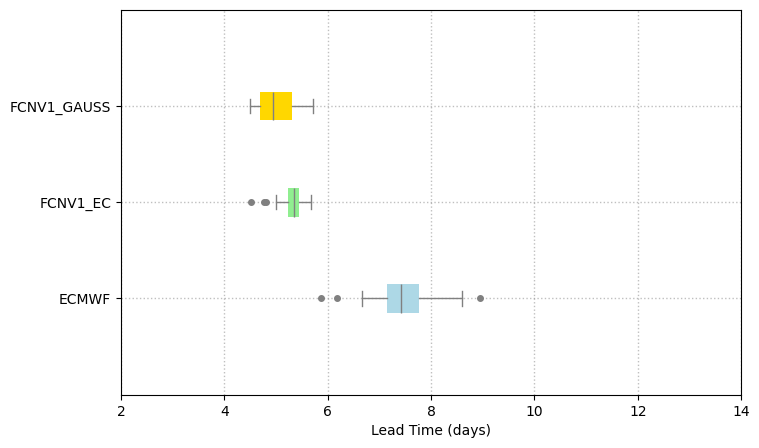

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have data arrays defined (lt_gain_ec_t2m_5k, lt_gain_fcnv1_ec_t2m_5k, lt_gain_fcnv1_era_t2m_5k)

fig, ax = plt.subplots(figsize=(8, 5))

# Define colors and positions for each box
box_colors = ['lightblue', 'lightgreen', 'gold']
box_positions = [1 ,1.5, 2]  # Adjust these positions as needed
box_labels = ['ECMWF', 'FCNV1_EC', 'FCNV1_GAUSS']  # Make sure the length matches the number of boxes

for i, (data, color, position) in enumerate(zip([lt_gain_ec_pf_large, lt_gain_fc_ec_pf_large, lt_gain_fc_era_pf_large], box_colors, box_positions)):
    box_properties = dict(facecolor=color, edgecolor='black', linewidth=0)
    whisker_properties = dict(color='grey',linewidth=1)
    cap_properties = dict(color='grey',linewidth=1)
    outlier_properties = dict(marker='o', markerfacecolor='grey', markersize=4, markeredgecolor='grey')
    #fliers_properties = dict(marker='s', markerfacecolor='blue', markersize=8, markeredgecolor='black')
    
    # Use position to set the specific y-axis position for each boxplot
    plt.boxplot(data, positions=[position], labels=[box_labels[i]],  # Use the corresponding label
                vert=False, boxprops=box_properties, whiskerprops = whisker_properties,capprops = cap_properties, showfliers=True, patch_artist=True,medianprops=dict(color='grey'),flierprops=outlier_properties)

# Set the y-axis label
ax.set_xlabel('Lead Time (days)')
ax.set_xticks([2,4,6,8,10,12,14])
plt.grid(True, linestyle='dotted', linewidth=1, color='gray', alpha=0.5)
#bbox_props = dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white")
#ax.text(7.5, 0.7, f"Lead time gain compared to FCNV1_GAUSS: {lt_gain_fcnv1_era} \nLead time gain compared to FCNV1_EC:  {lt_gain_fcnv1_ec} ", ha='left', va='center', color='grey', fontsize=9, bbox=bbox_props)
plt.savefig('/home/kit/imk-tro/gj5173/not_finalized_yet_plots/leadtime_gain_t850_5k_withouttext.png', bbox_inches='tight',dpi=200)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have data arrays defined (lt_gain_ec_t2m_5k, lt_gain_fcnv1_ec_t2m_5k, lt_gain_fcnv1_era_t2m_5k)

fig, ax = plt.subplots(figsize=(8,5))

# Define colors and positions for each box
box_colors = ['lightblue', 'lightgreen', 'gold']
box_positions = [1 ,1.5, 2]  # Adjust these positions as needed
box_labels = ['ECMWF', 'FCNV1_EC', 'FCNV1_GAUSS']  # Make sure the length matches the number of boxes

for i, (data, color, position) in enumerate(zip([lt_gain_ec_pf_large, lt_gain_fc_ec_pf_large, lt_gain_fc_era_pf_large], box_colors, box_positions)):
    box_properties = dict(facecolor=color, edgecolor='grey', linewidth=0)
    whisker_properties = dict(color='grey',linewidth=1)
    cap_properties = dict(color='grey',linewidth=1)
    outlier_properties = dict(marker='o', markerfacecolor='grey', markersize=4, markeredgecolor='grey')
    #fliers_properties = dict(marker='s', markerfacecolor='blue', markersize=8, markeredgecolor='black')
    
    # Use position to set the specific y-axis position for each boxplot
    plt.boxplot(data, positions=[position], labels=[box_labels[i]],  # Use the corresponding label
                vert=False, boxprops=box_properties, whiskerprops = whisker_properties,capprops = cap_properties, showfliers=True, patch_artist=True,medianprops=dict(color='grey'),flierprops=outlier_properties)

# Set the y-axis label
ax.set_xlabel('Lead Time (days)')
ax.set_xticks([2,4,6,8,10,12,14])
plt.grid(True, linestyle='dotted', linewidth=1, color='gray', alpha=0.5)
bbox_props = dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white")
ax.text(7.5, 0.7, f"Lead time gain compared to FCNV1_GAUSS: {lt_gain_fcnv1_era} \nLead time gain compared to FCNV1_EC:  {lt_gain_fcnv1_ec} ", ha='left', va='center', color='grey', fontsize=9, bbox=bbox_props)
#plt.savefig('/home/kit/imk-tro/gj5173/not_finalized_yet_plots/leadtime_gain_z500_0.6_withtex.png', bbox_inches='tight',dpi=200)
plt.show()

In [ ]:
###################################### acc z500 lead time gain plot #######################################################

In [47]:
#try with old data
%store -r acc_fc_era_box
%store -r acc_fc_ec_box
%store -r acc_ec_box
%store -r acc_ec_cf_box

%store -r acc_fc_ec_cf_box
%store -r acc_fc_ec_cf_box_big
%store -r acc_fc_ec_cf_box_whole

%store -r acc_fc_era_box_big
%store -r acc_fc_era_box_whole
%store -r acc_fc_era_box


%store -r acc_ec_box
%store -r acc_ec_box_big
%store -r acc_ec_box_whole

%store -r acc_fc_ec_box
%store -r acc_fc_ec_box_big
%store -r acc_fc_ec_box_whole

%store -r acc_ec_cf_box_big
%store -r acc_ec_cf_box_whole

In [14]:
np.shape(acc_fc_era_box_big)

(15, 51)

In [48]:
acc_fc_era_pf_box_big = acc_fc_era_box_big[:,0:50]

In [16]:
np.shape(acc_fc_era_pf_box_big)

(15, 50)

In [51]:
acc_fc_ec_box[14,:] = acc_ec_box[14,:]
acc_fc_ec_cf_box[14] = acc_ec_cf_box[14]
acc_fc_ec_box_big[14,:] = acc_ec_box_big[14,:]
acc_fc_ec_cf_box_big[14] = acc_ec_cf_box_big[14]
acc_fc_ec_box_whole[14,:] = acc_ec_box_whole[14,:]
acc_fc_ec_cf_box_whole[14] = acc_ec_cf_box_whole[14]

In [2]:
#store the acc of ecmwf
%store -r acc_ec_z500_box_0629
%store -r acc_ec_z500_big_0629 
%store -r acc_ec_z500_whole_0629 
%store -r acc_ec_z500_box_0629_ens 
%store -r acc_ec_z500_big_0629_ens 
%store -r acc_ec_z500_whole_0629_ens


#store the acc of fcn_ecmwf
%store -r acc_fcnv1_ec_z500_box_0629 
%store -r acc_fcnv1_ec_z500_big_0629 
%store -r acc_fcnv1_ec_z500_whole_0629
%store -r acc_fcnv1_ec_z500_box_0629_ens 
%store -r acc_fcnv1_ec_z500_big_0629_ens 
%store -r acc_fcnv1_ec_z500_whole_0629_ens 


#store the acc of fcn_era
%store -r acc_fcnv1_era_z500_box_0629 
%store -r acc_fcnv1_era_z500_big_0629 
%store -r acc_fcnv1_era_z500_whole_0629 
%store -r acc_fcnv1_era_z500_box_0629_ens 
%store -r acc_fcnv1_era_z500_big_0629_ens 
%store -r acc_fcnv1_era_z500_whole_0629_ens 

In [3]:
acc_fcnv1_ec_z500_big_0629_ens[14,:] = acc_ec_z500_big_0629_ens[14,:]

In [79]:
#do not interpolate and directly calculate the point
import numpy as np
from scipy.interpolate import interp1d
lt_gain_ec_pf_large=[]
for i in range(50):
    data = acc_ec_z500_big_0629_ens[::-1,i]
    x_values = np.arange(len(data))#set
    #interp_function = interp1d(x_values, data, kind='linear', fill_value='extrapolate')#set
    #fine_x_values = np.linspace(0, len(data) - 1, 1000)#set
    #interpolated_data = interp_function(fine_x_values)
    index_of_first_point = np.where(data < 0.6)[0][0]
    print(index_of_first_point)
    #x_value = data[index_of_first_point]
    x_value_reverse = 14-x_value
    lt_gain_ec_pf_large.append(index_of_first_point)
#lt_gain_ec_pf

7
9
9
10
8
8
10
9
9
7
8
10
9
10
9
10
10
9
8
8
7
11
6
10
8
10
9
11
8
10
9
9
8
7
8
9
8
7
9
11
9
7
10
8
8
10
9
8
6
9


In [80]:
#do not interpolate and directly calculate the point
import numpy as np
from scipy.interpolate import interp1d
lt_gain_fcnv1_ec_pf_large=[]
for i in range(50):
    data = acc_fcnv1_ec_z500_big_0629_ens[::-1,i]
    x_values = np.arange(len(data))#set
    #interp_function = interp1d(x_values, data, kind='linear', fill_value='extrapolate')#set
    #fine_x_values = np.linspace(0, len(data) - 1, 1000)#set
    #interpolated_data = interp_function(fine_x_values)
    index_of_first_point = np.where(data < 0.6)[0][0]
    print(index_of_first_point)
    #x_value = data[index_of_first_point]
    x_value_reverse = 14-x_value
    lt_gain_fcnv1_ec_pf_large.append(index_of_first_point)
#lt_gain_ec_pf

8
8
9
6
6
7
8
10
8
8
8
9
8
8
8
8
9
8
7
8
7
6
9
9
8
7
10
7
10
10
8
6
8
7
9
8
8
9
9
8
8
7
8
8
8
6
8
8
6
8


In [82]:
#do not interpolate and directly calculate the point
import numpy as np
from scipy.interpolate import interp1d
lt_gain_fcnv1_era_pf_large=[]
for i in range(50):
    data = acc_fcnv1_era_z500_big_0629_ens[::-1,i]
    x_values = np.arange(len(data))#set
    #interp_function = interp1d(x_values, data, kind='linear', fill_value='extrapolate')#set
    #fine_x_values = np.linspace(0, len(data) - 1, 1000)#set
    #interpolated_data = interp_function(fine_x_values)
    index_of_first_point = np.where(data < 0.6)[0][0]
    print(index_of_first_point)
    #x_value = data[index_of_first_point]
    x_value_reverse = 14-x_value
    lt_gain_fcnv1_era_pf_large.append(index_of_first_point)

8
7
6
7
8
6
7
6
10
6
6
7
8
6
6
7
8
6
6
7
7
6
6
6
9
7
7
9
6
6
6
6
6
8
6
8
6
6
6
7
10
8
7
8
7
8
7
6
7
8


In [85]:
import numpy as np
from scipy.interpolate import interp1d
lt_gain_ec_pf_large=[]
for i in range(50):
    data = acc_ec_z500_big_0629_ens[::-1,i]
    x_values = np.arange(len(data))#set
    interp_function = interp1d(x_values, data, kind='linear', fill_value='extrapolate')#set
    fine_x_values = np.linspace(0, len(data) - 1, 1000)#set
    interpolated_data = interp_function(fine_x_values)
    index_of_first_point = np.where(interpolated_data < 0.6)[0][0]
    x_value = fine_x_values[index_of_first_point]
    x_value_reverse = 14-x_value
    lt_gain_ec_pf_large.append(x_value)
#lt_gain_ec_pf

In [86]:
lt_gain_fc_ec_pf_large=[]
for i in range(50):
    data = acc_fcnv1_ec_z500_big_0629_ens[::-1,i]
    x_values = np.arange(len(data))#set
    interp_function = interp1d(x_values, data, kind='linear', fill_value='extrapolate')#set
    fine_x_values = np.linspace(0, len(data) - 1, 1000)#set
    interpolated_data = interp_function(fine_x_values)
    index_of_first_point = np.where(interpolated_data < 0.6)[0][0]
    x_value = fine_x_values[index_of_first_point]
    x_value_reverse = 14-x_value
    lt_gain_fc_ec_pf_large.append(x_value)

In [58]:
acc_fcnv1_ec_z500_big_0629_ens[13,:]

array([0.99608889, 0.99560724, 0.99583618, 0.99604656, 0.99609978,
       0.99590901, 0.99619159, 0.99622836, 0.9966268 , 0.99606292,
       0.99564238, 0.99640468, 0.99716296, 0.99462358, 0.99731098,
       0.99700187, 0.99670688, 0.99600933, 0.99635126, 0.99657427,
       0.99740995, 0.99593951, 0.99682598, 0.99603482, 0.99704663,
       0.99719617, 0.99656753, 0.99571122, 0.99610817, 0.9972425 ,
       0.99597849, 0.99549732, 0.99446391, 0.99658286, 0.99648597,
       0.99695381, 0.99595279, 0.99575792, 0.99517433, 0.99751861,
       0.99689378, 0.99678862, 0.99552062, 0.99666493, 0.99664344,
       0.99608938, 0.99490243, 0.99720571, 0.99449603, 0.99586383])

In [87]:
lt_gain_fc_era_pf_large=[]
for i in range(50):
    data = acc_fcnv1_era_z500_big_0629_ens[::-1,i]
    x_values = np.arange(len(data))#set
    interp_function = interp1d(x_values, data, kind='linear', fill_value='extrapolate')#set
    fine_x_values = np.linspace(0, len(data) - 1, 1000)#set
    interpolated_data = interp_function(fine_x_values)
    index_of_first_point = np.where(interpolated_data < 0.6)[0][0]
    x_value = fine_x_values[index_of_first_point]
    x_value_reverse = 14-x_value
    lt_gain_fc_era_pf_large.append(x_value)

In [ ]:
#calculate the median of lead time to get the lead time gain

lt_median_ec = np.median(lt_gain_ec_pf_large)
lt_median_fcnv1_ec = np.median(lt_gain_fc_ec_pf_large)
lt_median_fcnv1_era = np.median(lt_gain_fc_era_pf_large)
lt_gain_fcnv1_ec = lt_median_ec - lt_median_fcnv1_ec
lt_gain_fcnv1_era = lt_median_ec - lt_median_fcnv1_era


lt_gain_fcnv1_ec = "{:.2f}".format(lt_gain_fcnv1_ec)
lt_gain_fcnv1_era = "{:.2f}".format(lt_gain_fcnv1_era)

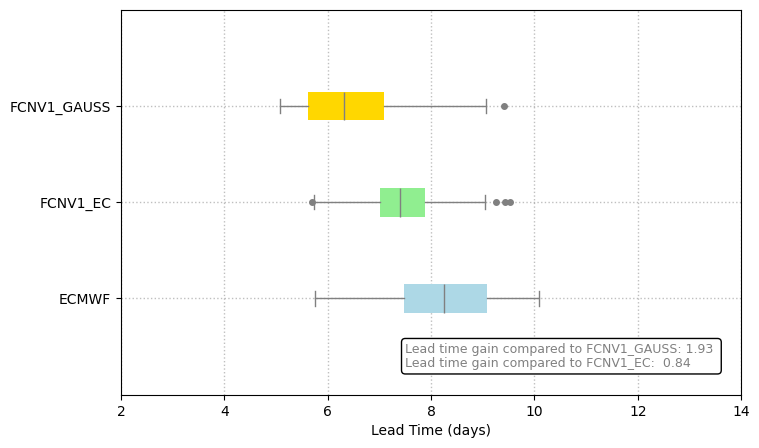

In [88]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have data arrays defined (lt_gain_ec_t2m_5k, lt_gain_fcnv1_ec_t2m_5k, lt_gain_fcnv1_era_t2m_5k)

fig, ax = plt.subplots(figsize=(8,5))

# Define colors and positions for each box
box_colors = ['lightblue', 'lightgreen', 'gold']
box_positions = [1 ,1.5, 2]  # Adjust these positions as needed
box_labels = ['ECMWF', 'FCNV1_EC', 'FCNV1_GAUSS']  # Make sure the length matches the number of boxes

for i, (data, color, position) in enumerate(zip([lt_gain_ec_pf_large, lt_gain_fc_ec_pf_large, lt_gain_fc_era_pf_large], box_colors, box_positions)):
    box_properties = dict(facecolor=color, edgecolor='grey', linewidth=0)
    whisker_properties = dict(color='grey',linewidth=1)
    cap_properties = dict(color='grey',linewidth=1)
    outlier_properties = dict(marker='o', markerfacecolor='grey', markersize=4, markeredgecolor='grey')
    #fliers_properties = dict(marker='s', markerfacecolor='blue', markersize=8, markeredgecolor='black')
    
    # Use position to set the specific y-axis position for each boxplot
    plt.boxplot(data, positions=[position], labels=[box_labels[i]],  # Use the corresponding label
                vert=False, boxprops=box_properties, whiskerprops = whisker_properties,capprops = cap_properties, showfliers=True, patch_artist=True,medianprops=dict(color='grey'),flierprops=outlier_properties)

# Set the y-axis label
ax.set_xlabel('Lead Time (days)')
ax.set_xticks([2,4,6,8,10,12,14])
plt.grid(True, linestyle='dotted', linewidth=1, color='gray', alpha=0.5)
bbox_props = dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white")
ax.text(7.5, 0.7, f"Lead time gain compared to FCNV1_GAUSS: {lt_gain_fcnv1_era} \nLead time gain compared to FCNV1_EC:  {lt_gain_fcnv1_ec} ", ha='left', va='center', color='grey', fontsize=9, bbox=bbox_props)
#plt.savefig('/home/kit/imk-tro/gj5173/not_finalized_yet_plots/leadtime_gain_z500_0.6_withtex.png', bbox_inches='tight',dpi=200)
plt.show()

In [ ]:
boxprops = dict(color='black', linewidth=1)
colors = [ 'lightblue','lightgreen','gold']
#boxprops = dict(color='blue', linewidth=2)
plt.boxplot([lt_gain_ec_pf_large, lt_gain_fc_ec_pf_large, lt_gain_fc_era_pf_large], labels=['ECMWF', 'FCN(EC)', 'FCN(ERA5)'],vert=False,boxprops=boxprops,showfliers=True)


plt.ylabel('Dataset')
plt.xlabel('Lead Time(days)')

plt.title('Z500_large-box')
#plt.savefig('/home/kit/imk-tro/gj5173/plots_lead_time_gain/z500_large_lg_boxplot', bbox_inches='tight',dpi=100)

In [54]:
acc_fc_era_pf_box = acc_fc_era_box[:,1:51]
np.shape(acc_fc_era_pf_box)

(15, 50)

In [61]:
import numpy as np
from scipy.interpolate import interp1d
lt_gain_ec_pf=[]
for i in range(50):
    data = acc_ec_box[::-1,i]
    x_values = np.arange(len(data))#set
    interp_function = interp1d(x_values, data, kind='linear', fill_value='extrapolate')#set
    fine_x_values = np.linspace(0, len(data) - 1, 1000)#set
    interpolated_data = interp_function(fine_x_values)
    index_of_first_point = np.where(interpolated_data < 0.6)[0][0]
    x_value = fine_x_values[index_of_first_point]
    x_value_reverse = 14-x_value
    lt_gain_ec_pf.append(x_value)
#lt_gain_ec_pf

In [62]:
lt_gain_fc_ec_pf=[]
for i in range(50):
    data = acc_fc_ec_box[::-1,i]
    x_values = np.arange(len(data))#set
    interp_function = interp1d(x_values, data, kind='linear', fill_value='extrapolate')#set
    fine_x_values = np.linspace(0, len(data) - 1, 1000)#set
    interpolated_data = interp_function(fine_x_values)
    index_of_first_point = np.where(interpolated_data < 0.6)[0][0]
    x_value = fine_x_values[index_of_first_point]
    x_value_reverse = 14-x_value
    lt_gain_fc_ec_pf.append(x_value)

In [73]:
lt_gain_fc_era_pf=[]
for i in range(50):
    data = acc_fc_era_pf_box[::-1,i]
    x_values = np.arange(len(data))#set
    interp_function = interp1d(x_values, data, kind='linear', fill_value='extrapolate')#set
    fine_x_values = np.linspace(0, len(data) - 1, 1000)#set
    interpolated_data = interp_function(fine_x_values)
    index_of_first_point = np.where(interpolated_data < 0.9)[0][0]
    x_value = fine_x_values[index_of_first_point]
    x_value_reverse = 14-x_value
    lt_gain_fc_era_pf.append(x_value)

In [ ]:
boxprops = dict(color='black', linewidth=1)
colors = [ 'lightblue','lightgreen','lightpink']
#boxprops = dict(color='blue', linewidth=2)
plt.boxplot([lt_gain_ec_pf, lt_gain_fc_ec_pf, lt_gain_fc_era_pf], labels=['ECMWF', 'FCN(EC)', 'FCN(ERA5)'],vert=False,boxprops=boxprops,showfliers=True)


plt.ylabel('Dataset')
plt.xlabel('Lead Time Gain(days)')

plt.title('Z500_small-box')

#plt.savefig('/home/kit/imk-tro/gj5173/plots_lead_time_gain/z500_small_lg_boxplot', bbox_inches='tight',dpi=100)